# Import

In [778]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from functions.khi_2 import cramers_v

# Link / objectives

Energy star : https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results

Problématique de la ville de Seattle
Des relevés minutieux ont été effectués par vos agents en __2015 et en 2016__. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de __l’"ENERGY STAR Score"__ pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

Votre mission:

- __Réaliser une courte analyse exploratoire.__
- __Tester différents modèles de prédiction afin de répondre au mieux à la problématique.__\


Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

- L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

- Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

- Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

# Load and clean

## Load Data

In [2]:
df_2015=pd.read_csv('./data/2015-building-energy-benchmarking.csv')
df_2016=pd.read_csv('./data/2016-building-energy-benchmarking.csv')

Le fait d'avoir deux datasets est embetant -> je vais essayer de les concatener sans perdre de la data

## Columns analysis

Analyse des colonnes pour pouvoir concat les deux datasets

In [3]:
len(df_2015.columns)==len(df_2016.columns)

False

In [4]:
col_2015=[]
for column in list(df_2015.columns):
    if column not in (df_2016.columns):
        col_2015.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2015]

colonnes de 2015 non présente dans 2016 : 
- Location
- OtherFuelUse(kBtu)
- GHGEmissions(MetricTonsCO2e)
- GHGEmissionsIntensity(kgCO2e/ft2)
- Comment
- 2010 Census Tracts
- Seattle Police Department Micro Community Policing Plan Areas
- City Council Districts
- SPD Beats
- Zip Codes


[None, None, None, None, None, None, None, None, None, None]

In [5]:
col_2016=[]
for column in list(df_2016.columns):
    if column not in (df_2015.columns):
        col_2016.append(column)
print(f"colonnes de 2015 non présente dans 2016 : ")
[print(f'- {i}') for i in col_2016]

colonnes de 2015 non présente dans 2016 : 
- Address
- City
- State
- ZipCode
- Latitude
- Longitude
- Comments
- TotalGHGEmissions
- GHGEmissionsIntensity


[None, None, None, None, None, None, None, None, None]

<AxesSubplot:xlabel='variable', ylabel='value'>

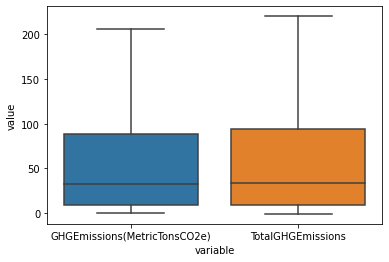

In [6]:
concat_data_1 =pd.concat([df_2015['GHGEmissions(MetricTonsCO2e)'], df_2016['TotalGHGEmissions']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_1), showfliers=False)

In [7]:
#seems the same

<AxesSubplot:xlabel='variable', ylabel='value'>

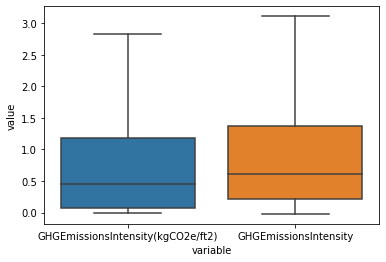

In [8]:
concat_data_2 =pd.concat([df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'], df_2016['GHGEmissionsIntensity']], axis=1)
sns.boxplot(x="variable", y="value", data=pd.melt(concat_data_2), showfliers=False)

In [9]:
#seems the same

In [10]:
df_2015['OtherFuelUse(kBtu)'].value_counts()

0.0          3313
6464408.0       1
178094.0        1
143134.0        1
5596.0          1
229942.0        1
145944.0        1
427938.0        1
1943011.0       1
12551.0         1
547.0           1
15527.0         1
2304567.0       1
2944419.0       1
337952.0        1
8269669.0       1
177849.0        1
182715.0        1
Name: OtherFuelUse(kBtu), dtype: int64

__Todo :__\
__2015__ 
 - Location : extract data [latitude and longitude, adress, ...]
 - comment/comments ->rename
 - GHGEmissions(MetricTonsCO2e) <->TotalGHGEmissions au vue de la data -> rename
 - 'GHGEmissionsIntensity(kgCO2e/ft2)' <-> 'GHGEmissionsIntensity' -> rename
 - OtherFuelUse(kBtu) : peu d'info -> drop
 - Seattle Police Department Micro Community Policing Plan Areas -> semble non relié à notre probleme -> drop
 - City Council Districts : idem -> drop
 - SPD Beats : semble être des problématique police -> drop
 - Zip Codes : je sais ap ce que c'est -> drop


## Data engeeniring for concat

### deal with Location column

In [11]:
# eval - > permet d'eviter d'avoir un format pourri
df_2015['Location'] = [eval(str(item)) for index, item in df_2015.Location.iteritems()]

In [12]:
df_2015['Latitude'] = df_2015['Location'].apply(lambda x : x['latitude'])
df_2015['Longitude'] = df_2015['Location'].apply(lambda x : x['longitude'])
df_2015['City'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['city'])
df_2015['State'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['state'])
df_2015['ZipCode'] = df_2015['Location'].apply(lambda x : eval(x['human_address'])['zip'])

### Deal with renaming + drop

In [13]:
df_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)' : 'TotalGHGEmissions',
                       'GHGEmissionsIntensity(kgCO2e/ft2)' : 'GHGEmissionsIntensity',
                       'Comment':'Comments'},
              inplace=True)

In [14]:
df_2015.drop(columns=['OtherFuelUse(kBtu)',
                      'Seattle Police Department Micro Community Policing Plan Areas', 
                      'City Council Districts',
                      'SPD Beats',
                      'Zip Codes',
                      'Location'],
            inplace=True)

### Concat Df 🍾

In [15]:
list(df_2015.columns).sort() == list(df_2016.columns).sort()

True

In [800]:
df = pd.concat([df_2015, df_2016], axis=0)

In [801]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'DefaultData', 'Comments',
       'ComplianceStatus', 'Outlier', '2010 Census Tracts', 

# Data Explo

__Definitions :__
- __GFA__ = Gross Floor Area : is the total property square footage, as measured between the exterior walls of the building(s)

In [802]:
# REMOVE residential building !
df=df[~df.BuildingType.isin(['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)'])]
df.BuildingType.unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [803]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 3375
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3318 non-null   int64  
 1   DataYear                         3318 non-null   int64  
 2   BuildingType                     3318 non-null   object 
 3   PrimaryPropertyType              3318 non-null   object 
 4   PropertyName                     3318 non-null   object 
 5   TaxParcelIdentificationNumber    3317 non-null   object 
 6   CouncilDistrictCode              3318 non-null   int64  
 7   Neighborhood                     3318 non-null   object 
 8   YearBuilt                        3318 non-null   int64  
 9   NumberofBuildings                3316 non-null   float64
 10  NumberofFloors                   3310 non-null   float64
 11  PropertyGFATotal                 3318 non-null   int64  
 12  PropertyGFAParking  

In [804]:
cat_columns=[]
numeric_columns=[]
for column in list(df.columns):
    if df[column].dtype=='object' :
        cat_columns.append(column)
    else :
        numeric_columns.append(column)

In [805]:
df.select_dtypes('float').columns

Index(['NumberofBuildings', 'NumberofFloors', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', '2010 Census Tracts'],
      dtype='object')

## Numeric columns

### premiere analyse

In [806]:
df[numeric_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 3375
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3318 non-null   int64  
 1   DataYear                         3318 non-null   int64  
 2   CouncilDistrictCode              3318 non-null   int64  
 3   YearBuilt                        3318 non-null   int64  
 4   NumberofBuildings                3316 non-null   float64
 5   NumberofFloors                   3310 non-null   float64
 6   PropertyGFATotal                 3318 non-null   int64  
 7   PropertyGFAParking               3318 non-null   int64  
 8   PropertyGFABuilding(s)           3318 non-null   int64  
 9   LargestPropertyUseTypeGFA        3247 non-null   float64
 10  SecondLargestPropertyUseTypeGFA  1667 non-null   float64
 11  ThirdLargestPropertyUseTypeGFA   684 non-null    float64
 12  ENERGYSTARScore     

OSEBuildingID


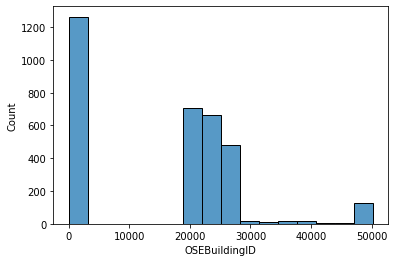

DataYear
2016    1668
2015    1650
Name: DataYear, dtype: int64


CouncilDistrictCode
7    1062
2     791
3     404
4     332
5     264
1     236
6     229
Name: CouncilDistrictCode, dtype: int64


YearBuilt


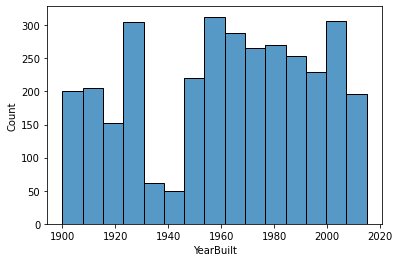

NumberofBuildings


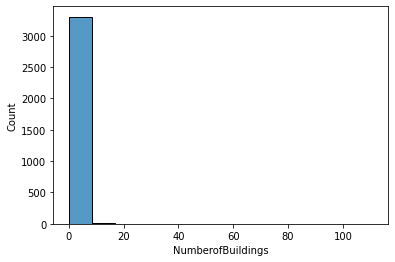

NumberofFloors


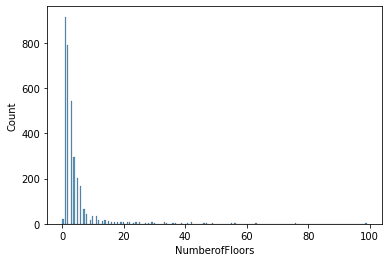

PropertyGFATotal


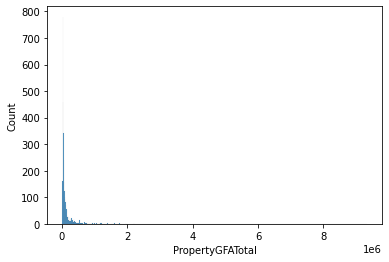

PropertyGFAParking


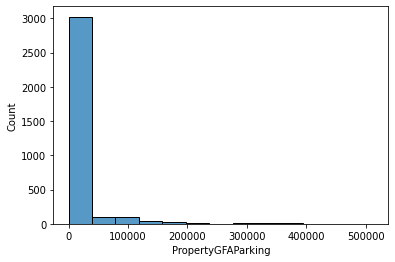

PropertyGFABuilding(s)


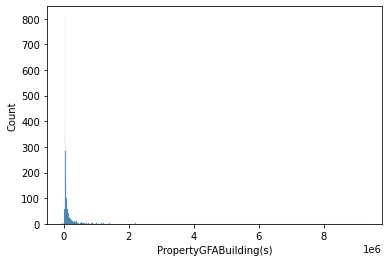

LargestPropertyUseTypeGFA


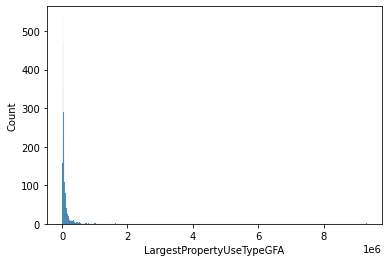

SecondLargestPropertyUseTypeGFA


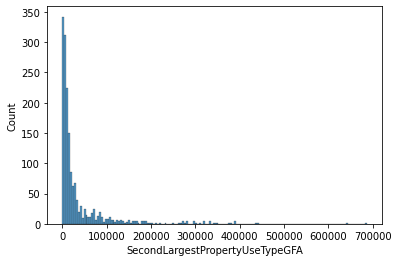

ThirdLargestPropertyUseTypeGFA


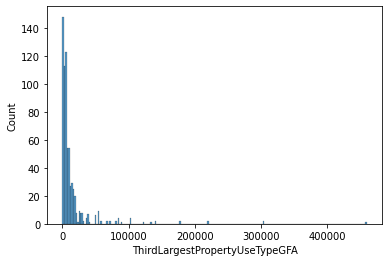

ENERGYSTARScore


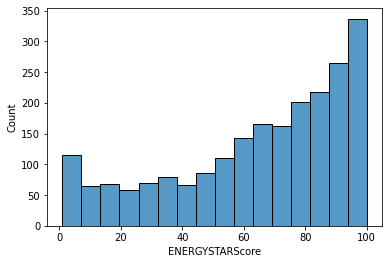

SiteEUI(kBtu/sf)


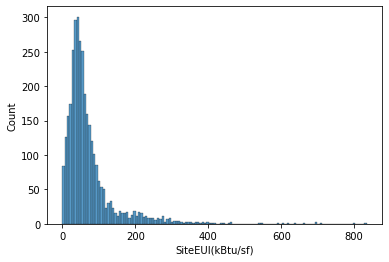

SiteEUIWN(kBtu/sf)


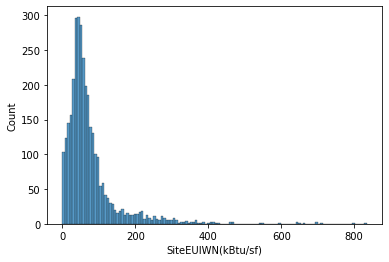

SourceEUI(kBtu/sf)


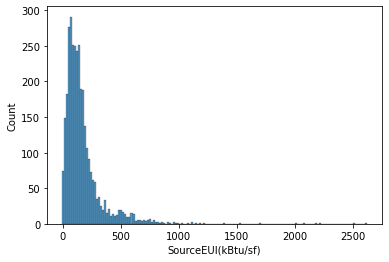

SourceEUIWN(kBtu/sf)


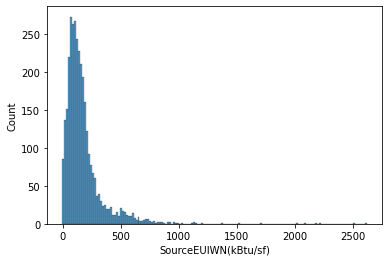

SiteEnergyUse(kBtu)


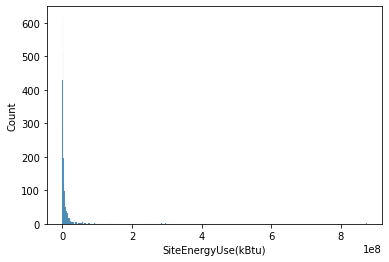

SiteEnergyUseWN(kBtu)


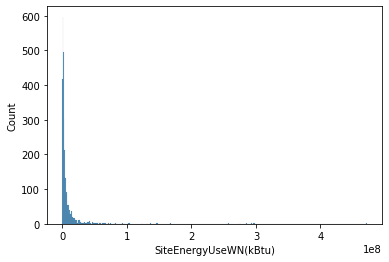

SteamUse(kBtu)


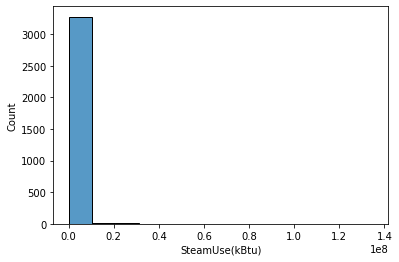

Electricity(kWh)


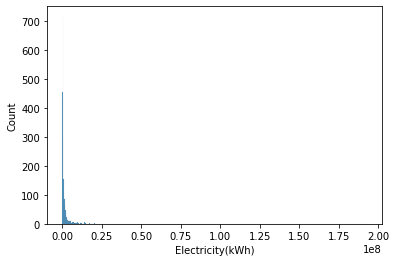

Electricity(kBtu)


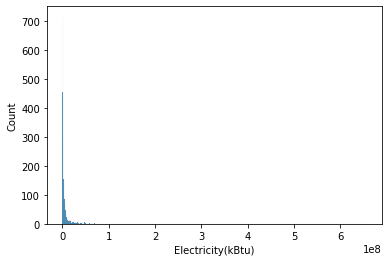

NaturalGas(therms)


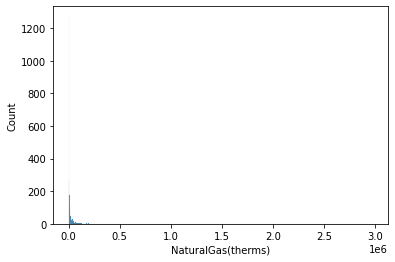

NaturalGas(kBtu)


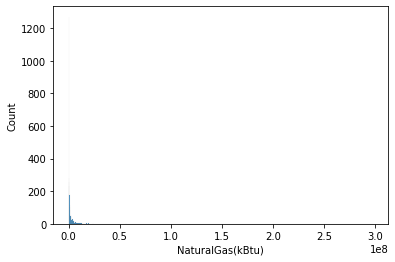

TotalGHGEmissions


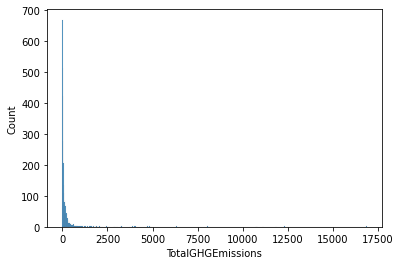

GHGEmissionsIntensity


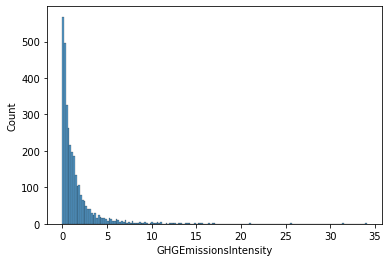

2010 Census Tracts


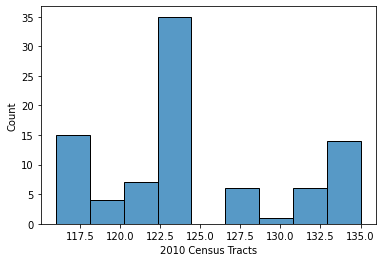

In [807]:
for column in numeric_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print('\n')
    else :
        print(column)
        sns.histplot(df[column])
        plt.show()

In [808]:
numeric_columns

['OSEBuildingID',
 'DataYear',
 'CouncilDistrictCode',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'ENERGYSTARScore',
 'SiteEUI(kBtu/sf)',
 'SiteEUIWN(kBtu/sf)',
 'SourceEUI(kBtu/sf)',
 'SourceEUIWN(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'Electricity(kWh)',
 'Electricity(kBtu)',
 'NaturalGas(therms)',
 'NaturalGas(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 '2010 Census Tracts']

<AxesSubplot:>

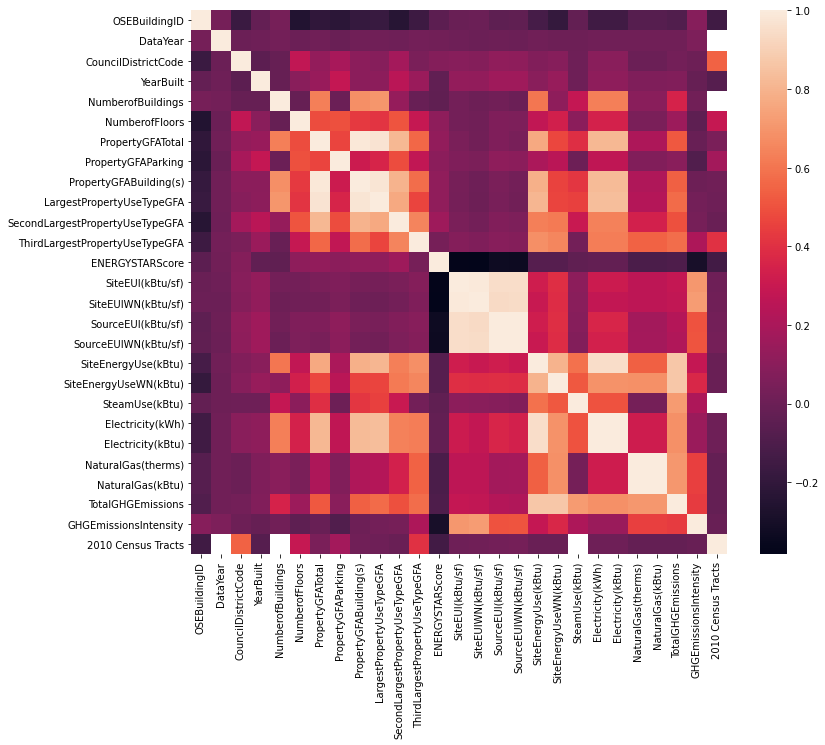

In [809]:
plt.figure(figsize=(12,10))
sns.heatmap(df[numeric_columns].corr())

In [810]:
corr = df.corr()
corr.style.background_gradient(cmap='Greens').set_precision(3)

/var/folders/rm/v4zjj0453jl2v5pmlsvnhgnc0000gn/T/ipykernel_48386/2921387194.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='Greens').set_precision(3)


colonne contenant WN:
- "Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot." -> semble peut pertinant à premiere vue 


In [811]:
numeric_to_drop=[
    'SiteEnergyUseWN(kBtu)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'Electricity(kWh)', #je garde en kwh
    'NaturalGas(therms)',
    '2010 Census Tracts',#trop d'outliers
    'LargestPropertyUseTypeGFA',# a voir
    'SecondLargestPropertyUseTypeGFA',#a voir
    'ThirdLargestPropertyUseTypeGFA',#a voir
    'SiteEUI(kBtu/sf)', # pour la problématique je suprime ces données dépendantes de la surface
    'SourceEUI(kBtu/sf)',# pour la problématique je suprime ces données dépendantes de la surface
    'GHGEmissionsIntensity',# pour la problématique je suprime ces données dépendantes de la surface
    'SteamUse(kBtu)', #à éviter car provient de relevé
    'Electricity(kBtu)', #à éviter car provient de relevé
    'NaturalGas(kBtu)', #à éviter car provient de relevé
    'PropertyGFATotal' #du à la corrélation avec PropertyGFPrking /Building(s)
    ]

In [812]:
df.drop(columns=numeric_to_drop, inplace=True)

In [813]:
numeric_columns = [i for i in numeric_columns if i not in numeric_to_drop]

### Check outliers

In [814]:
df[numeric_columns].describe()

OSEBuildingID     DataYear  CouncilDistrictCode    YearBuilt  \
count    3318.000000  3318.000000          3318.000000  3318.000000   
mean    15951.816154  2015.502712             4.365883  1961.536769   
std     13411.897096     0.500068             2.195304    32.709772   
min         1.000000  2015.000000             1.000000  1900.000000   
25%       579.000000  2015.000000             2.000000  1930.000000   
50%     21122.000000  2016.000000             4.000000  1965.000000   
75%     24556.750000  2016.000000             7.000000  1989.000000   
max     50226.000000  2016.000000             7.000000  2015.000000   

       NumberofBuildings  NumberofFloors  PropertyGFAParking  \
count        3316.000000     3310.000000         3318.000000   
mean            1.117310        4.126888        13303.304702   
std             2.219845        6.567333        43596.620504   
min             0.000000        0.000000           -2.000000   
25%             1.000000        1.000000            0.000000   
50%             1.000000        2.000000            0.000000   
75%             1.000000        4.000000            0.000000   
max           111.000000       99.000000       512608.000000   

       PropertyGFABuilding(s)  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
count            3.318000e+03      2211.000000         3.309000e+03   
mean             1.023639e+05        64.815920         8.068625e+06   
std              2.340749e+05        28.549886         2.525462e+07   
min             -5.055000e+04         1.000000         0.000000e+00   
25%              2.850775e+04        47.000000         1.223425e+06   
50%              4.736800e+04        72.000000         2.505271e+06   
75%              9.447150e+04        89.000000         6.917280e+06   
max              9.320156e+06       100.000000         8.739237e+08   

       TotalGHGEmissions  
count        3309.000000  
mean          177.038779  
std           666.442480  
min            -0.800000  
25%            19.720000  
50%            49.160000  
75%           138.870000  
max         16870.980000

__Pour remplir les données manquantes des étages/nombres de batiments :__
- remplir par la vaeur associé à l'id du batiment de l'autre année
- par défaut : par 0
- puis remplacer 0 par 1.. *-> à voir implémentation méthode par la moyenne des batiements de la même catégorie ?*

In [815]:
#NumberofBuildings
df['NumberofBuildings'] = df['NumberofBuildings'].fillna(df.groupby('OSEBuildingID')['NumberofBuildings'].transform('max'))
df['NumberofBuildings']=df['NumberofBuildings'].fillna(0)
df['NumberofBuildings'] = df['NumberofBuildings'].replace(0.0, 1.0)
df['NumberofBuildings'].unique()

array([  1.,   7.,  11.,  16.,   4.,   3.,  39.,   2.,  10.,   6.,  27.,
        14.,   9.,   5.,   8.,  23., 111.])

In [816]:
#NumberofFloors cant be 0 floors + deal with outliers
df['NumberofFloors'] = df['NumberofFloors'].fillna(df.groupby('OSEBuildingID')['NumberofFloors'].transform('max'))
df['NumberofFloors'] = df['NumberofFloors'].replace(0.0, 1.0)

In [817]:
df['NumberofFloors'].value_counts()

1.0     943
2.0     789
3.0     541
4.0     295
5.0     202
6.0     167
7.0      67
8.0      43
11.0     36
10.0     35
14.0     17
12.0     16
9.0      16
15.0     13
13.0     13
19.0     10
42.0     10
17.0      8
29.0      6
21.0      6
22.0      6
16.0      6
20.0      6
24.0      6
33.0      6
25.0      6
18.0      6
23.0      5
34.0      4
36.0      4
41.0      4
46.0      2
99.0      2
76.0      2
27.0      2
56.0      2
30.0      2
63.0      2
55.0      2
37.0      2
49.0      2
28.0      2
47.0      2
39.0      2
Name: NumberofFloors, dtype: int64

In [818]:
#PropertyGFAParking
df['PropertyGFAParking']=df['PropertyGFAParking'].replace(-2.0, 0.0)
df['PropertyGFAParking'].min()

0

In [819]:
# PropertyGFABuilding(s)
property_gfa_building_neg = list(df[(df['PropertyGFABuilding(s)']<0)]['OSEBuildingID'])
for id_ in property_gfa_building_neg: 
    to_replace = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']<0)]['PropertyGFABuilding(s)'].item()
    value = df[(df['OSEBuildingID']==id_)&(df['PropertyGFABuilding(s)']>0)]['PropertyGFABuilding(s)'].item()
    df['PropertyGFABuilding(s)']=df['PropertyGFABuilding(s)'].replace(to_replace, value)

In [820]:
df['PropertyGFABuilding(s)'].min()

3636

## Cat Columns

In [821]:
for column in cat_columns:
    if len(df[column].value_counts())<10:
        print(column)
        print(df[column].value_counts())
        print(f"{len(df[df[column].isna()])} valeurs manquantes'")
        print('\n')
    else :
        print(f'la colonne {column} contient {len(df[column].value_counts())} valeurs différentes et {len(df[df[column].isna()])} valeurs manquantes')
        print('\n')
    

BuildingType
NonResidential        2921
SPS-District K-12      197
Nonresidential COS     153
Campus                  46
Nonresidential WA        1
Name: BuildingType, dtype: int64
0 valeurs manquantes'


la colonne PrimaryPropertyType contient 30 valeurs différentes et 0 valeurs manquantes


la colonne PropertyName contient 3204 valeurs différentes et 0 valeurs manquantes


la colonne TaxParcelIdentificationNumber contient 1835 valeurs différentes et 1 valeurs manquantes


la colonne Neighborhood contient 19 valeurs différentes et 0 valeurs manquantes


la colonne ListOfAllPropertyUseTypes contient 387 valeurs différentes et 63 valeurs manquantes


la colonne LargestPropertyUseType contient 57 valeurs différentes et 71 valeurs manquantes


la colonne SecondLargestPropertyUseType contient 47 valeurs différentes et 1651 valeurs manquantes


la colonne ThirdLargestPropertyUseType contient 40 valeurs différentes et 2634 valeurs manquantes


la colonne YearsENERGYSTARCertified contient 113

In [822]:
#BuildingType
df['BuildingType']=df['BuildingType'].replace('Nonresidential COS', 'NonResidential')
df['BuildingType']=df['BuildingType'].replace('Nonresidential WA', 'NonResidential')
df['BuildingType'].value_counts()

NonResidential       3075
SPS-District K-12     197
Campus                 46
Name: BuildingType, dtype: int64

In [823]:
df.groupby(['BuildingType'], as_index=False).mean()[['BuildingType','SiteEnergyUse(kBtu)']]

BuildingType  SiteEnergyUse(kBtu)
0             Campus         5.907564e+07
1     NonResidential         7.598376e+06
2  SPS-District K-12         3.347582e+06

In [824]:
len(df.PrimaryPropertyType.unique())

30

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

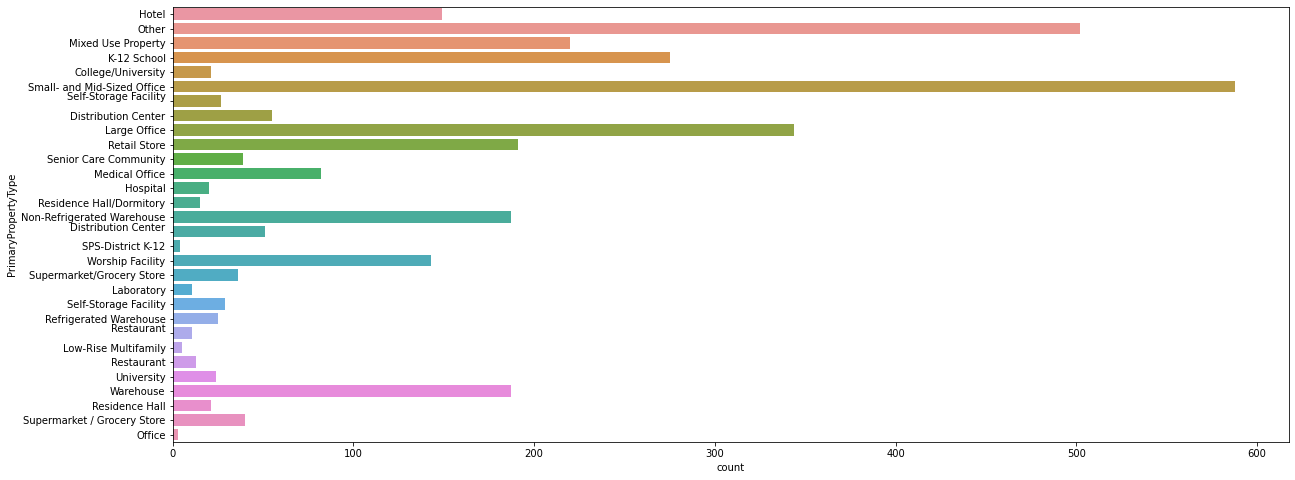

In [825]:
#PrimaryPropertyType
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [826]:
test = df[['PrimaryPropertyType', 'OSEBuildingID']]
dfg=test.groupby(['OSEBuildingID']).agg(set).reset_index()
dfg['taille'] = dfg['PrimaryPropertyType'].apply(lambda x : len(x))
list(dfg[dfg['taille']>1]['PrimaryPropertyType'])

[{'College/University', 'University'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Distribution Center', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Other', 'Retail Store'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'College/University', 'University'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'College/University', 'University'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Self-Storage Facility', 'Self-Storage Facility\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Distribution Center', 'Distribution Center\n'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'K-12 School', 'SPS-District K-12'},
 {'Non-Refrigerated Warehouse', 'Warehouse'},
 {'Residence Hall', 'Residence Hall/Dormitory'},
 {'Mixed Use Property', 'Other'},
 {'Non-Refrigerated 

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

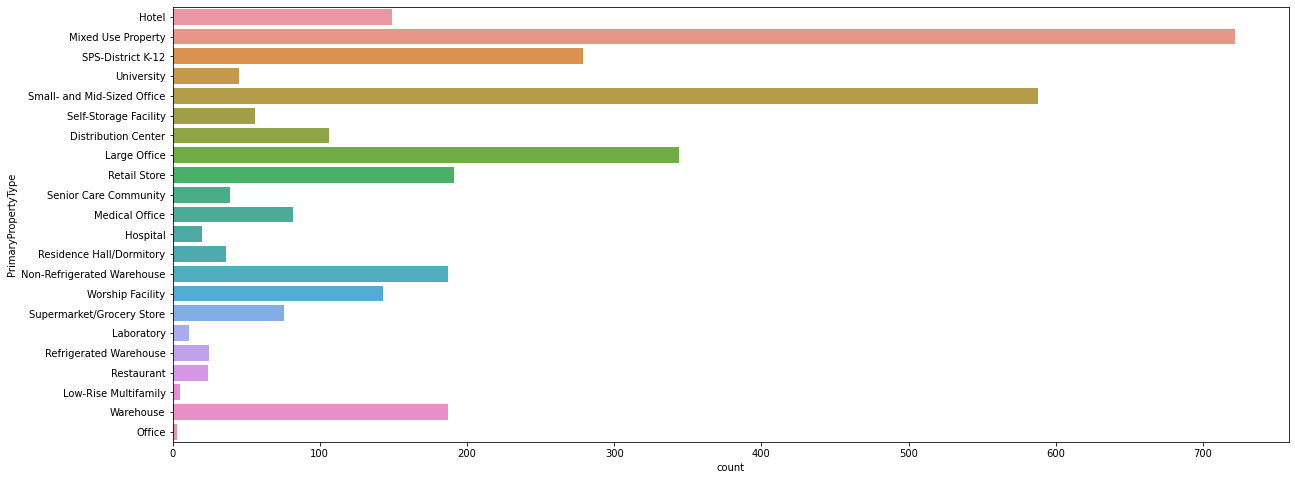

In [827]:
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('College/University', 'University')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Self-Storage Facility\n', 'Self-Storage Facility')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Distribution Center\n', 'Distribution Center')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Residence Hall', 'Residence Hall/Dormitory')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('K-12 School', 'SPS-District K-12')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Supermarket / Grocery Store', \
                                                            'Supermarket/Grocery Store')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Other', \
                                                            'Mixed Use Property')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Restaurant\n', 'Restaurant')
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [828]:
# check des distributions par primary property type
# j'enleve les low rise/mid rise multifamily car données trop nombereuses + outliers qui écrase distribution
def fill_mean(row):
    mean = df_mean[df_mean['PrimaryPropertyType']==row]['SiteEnergyUse(kBtu)'].item()
    return mean
df_test = df.copy()
df_test = df_test[df_test['SiteEnergyUse(kBtu)']<80000000]
df_mean = df_test.groupby(['PrimaryPropertyType'], as_index=False).mean()[['PrimaryPropertyType','SiteEnergyUse(kBtu)']]
df_test['mean_cat'] = df_test['PrimaryPropertyType'].apply(fill_mean)
df_test
df_test=df_test.sort_values(by=['mean_cat'])

<AxesSubplot:ylabel='SiteEnergyUse(kBtu)'>

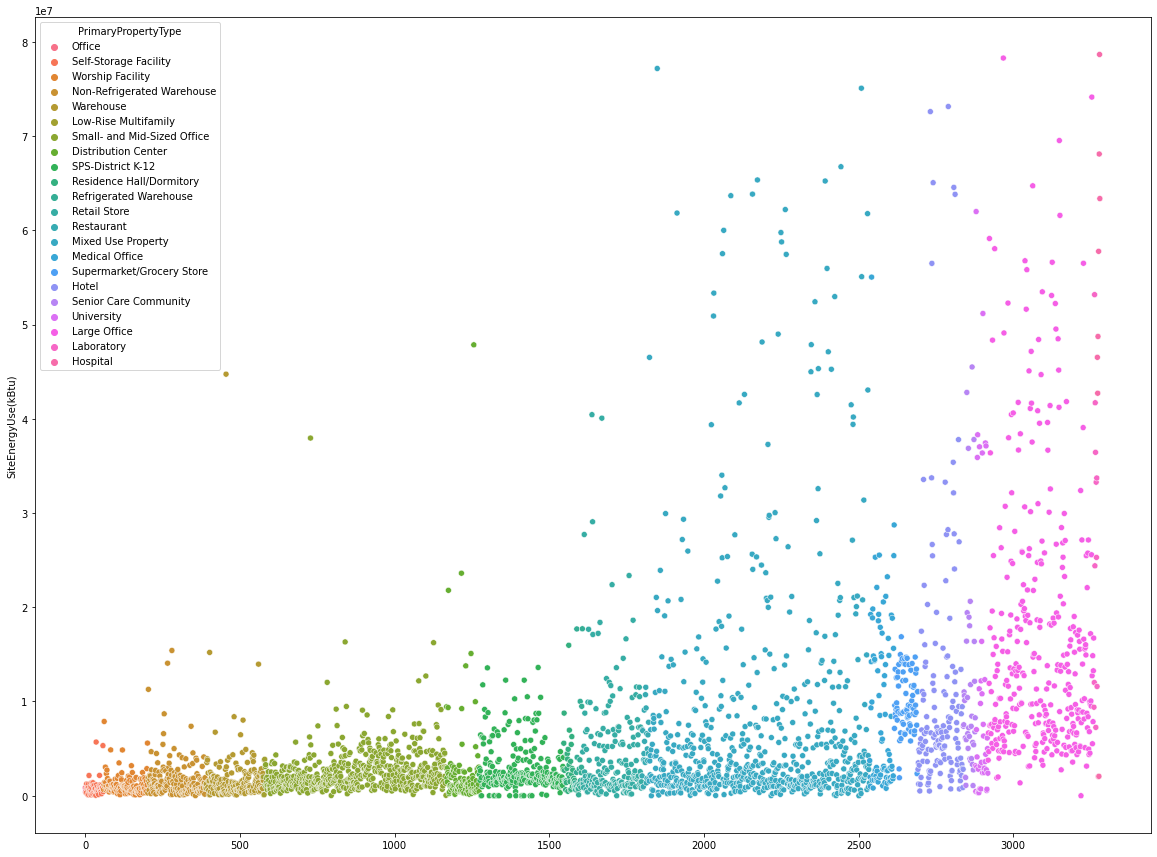

In [829]:
plt.figure(figsize=(20,15))
sns.scatterplot(y=df_test['SiteEnergyUse(kBtu)'], x=[i for i in range(len(df_test))], hue=df_test['PrimaryPropertyType'])


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)', ylabel='PrimaryPropertyType'>

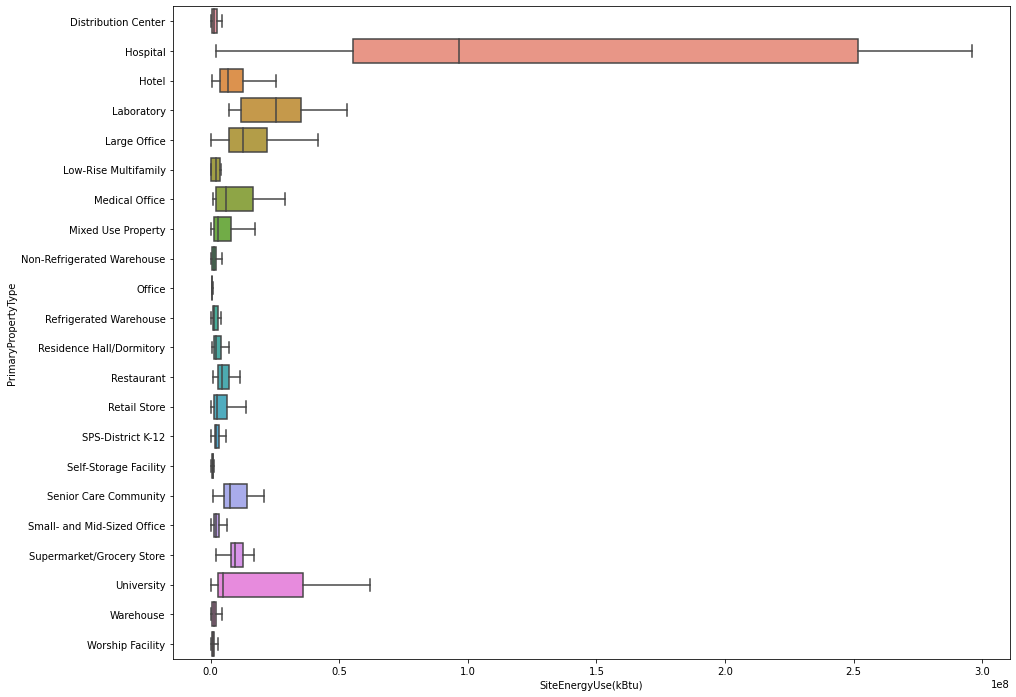

In [830]:
plt.figure(figsize=(15,12))
azerty = df[['SiteEnergyUse(kBtu)', 'PrimaryPropertyType']].sort_values(by='PrimaryPropertyType')
sns.boxplot(y='PrimaryPropertyType', x='SiteEnergyUse(kBtu)', data=azerty, orient='h', showfliers=False)

In [831]:
df_mean.sort_values(by='SiteEnergyUse(kBtu)')

PrimaryPropertyType  SiteEnergyUse(kBtu)
9                        Office         5.800745e+05
15        Self-Storage Facility         9.125161e+05
21             Worship Facility         1.171687e+06
8    Non-Refrigerated Warehouse         1.726504e+06
20                    Warehouse         1.961577e+06
5          Low-Rise Multifamily         1.968272e+06
17  Small- and Mid-Sized Office         2.610650e+06
0           Distribution Center         2.801173e+06
14            SPS-District K-12         2.905481e+06
11     Residence Hall/Dormitory         3.138390e+06
10       Refrigerated Warehouse         3.522608e+06
13                 Retail Store         4.864268e+06
12                   Restaurant         5.181074e+06
7            Mixed Use Property         7.934994e+06
6                Medical Office         9.583750e+06
18    Supermarket/Grocery Store         9.983782e+06
2                         Hotel         1.131862e+07
16        Senior Care Community         1.170678e+07
19                   University         1.190550e+07
4                  Large Office         1.703463e+07
3                    Laboratory         2.620197e+07
1                      Hospital         4.554688e+07

<AxesSubplot:xlabel='count', ylabel='PrimaryPropertyType'>

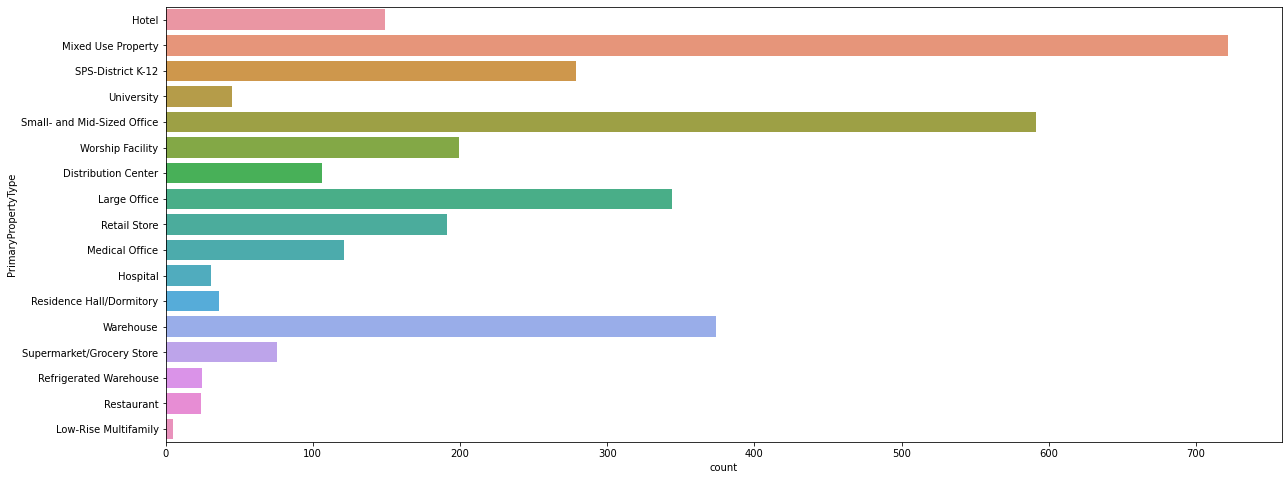

In [832]:
# au vu de ces données :
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Non-Refrigerated Warehouse', 'Warehouse')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Laboratory', 'Hospital')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Self-Storage Facility', 'Worship Facility')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Office', 'Small- and Mid-Sized Office')
df['PrimaryPropertyType']=df['PrimaryPropertyType'].replace('Senior Care Community', 'Medical Office')
plt.figure(figsize=(20,8))
sns.countplot(y=df['PrimaryPropertyType'], orient='v')

In [833]:
len(df['PrimaryPropertyType'].unique())

17

In [834]:
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Mixed Use Property', 'SPS-District K-12', 'University',
       'Small- and Mid-Sized Office', 'Worship Facility',
       'Distribution Center', 'Large Office', 'Retail Store',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Warehouse', 'Supermarket/Grocery Store', 'Refrigerated Warehouse',
       'Restaurant', 'Low-Rise Multifamily'], dtype=object)

In [835]:
#Neighborhood
df['Neighborhood']=df['Neighborhood'].str.upper()
df['Neighborhood']=df['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
print(df['Neighborhood'].value_counts())

DOWNTOWN                 728
GREATER DUWAMISH         686
MAGNOLIA / QUEEN ANNE    301
LAKE UNION               296
NORTHEAST                243
EAST                     242
NORTHWEST                174
BALLARD                  139
NORTH                    132
CENTRAL                  110
SOUTHEAST                 92
DELRIDGE                  92
SOUTHWEST                 83
Name: Neighborhood, dtype: int64


In [836]:
#ListOfAllPropertyUseTypes
df['PrimaryPropertyType'].unique()

array(['Hotel', 'Mixed Use Property', 'SPS-District K-12', 'University',
       'Small- and Mid-Sized Office', 'Worship Facility',
       'Distribution Center', 'Large Office', 'Retail Store',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Warehouse', 'Supermarket/Grocery Store', 'Refrigerated Warehouse',
       'Restaurant', 'Low-Rise Multifamily'], dtype=object)

In [837]:
df['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       nan, 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Retail Store', 'Senior Care Community',
       'Medical Office', 'Hospital (General Medical & Surgical)',
       'Museum', 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Multifamily Housing', 'Worship Facility', 'Laboratory',
       'Supermarket/Grocery Store', 'Convention Center',
       'Urgent Care/Clinic/Other Outpatient', 'Other - Services',
       'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

In [838]:
df_chi2=df.copy(deep=True)
df_chi2=df_chi2[(~df_chi2['SiteEnergyUse(kBtu)'].isna())&(~df_chi2['LargestPropertyUseType'].isna())]
# First, we need to calculate our IQR.
q1 = df_chi2['SiteEnergyUse(kBtu)'].quantile(0.25)                 
q3 = df_chi2['SiteEnergyUse(kBtu)'].quantile(0.75)
iqr = q3 - q1

# Now let's calculate upper and lower bounds.
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

# Let us create our bins:
num_bins = 10
bin_width = (upper - lower) / num_bins
bins = [lower + i*bin_width for i in range(num_bins)]
bins += [upper, float('inf')]  # Now we add our last bin, which will contain any value greater than the upper-bound of the IQR.

# Let us create our labels:
labels = [f'Bucket {i}' for i in range(1,num_bins+1)]
labels.append('Outside IQR')

# Finally, we add a new column to the df:
df_chi2['khi2'] = pd.cut(df_chi2['SiteEnergyUse(kBtu)'], bins=bins, labels=labels)
df_chi2.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  CouncilDistrictCode  \
0   MAYFLOWER PARK HOTEL                     659000030                    7   
1        PARAMOUNT HOTEL                     659000220                    7   
2           WESTIN HOTEL                     659000475                    7   
3              HOTEL MAX                     659000640                    7   
4  WARWICK SEATTLE HOTEL                     659000970                    7   

  Neighborhood  YearBuilt  NumberofBuildings  ...  Comments  ComplianceStatus  \
0     DOWNTOWN       1927                1.0  ...       NaN         Compliant   
1     DOWNTOWN       1996                1.0  ...       NaN         Compliant   
2     DOWNTOWN       1969                1.0  ...       NaN         Compliant   
3     DOWNTOWN       1926                1.0  ...       NaN         Compliant   
4     DOWNTOWN       1980                1.0  ...       NaN         Compliant   

        Outlier     Latitude      Longitude     City State ZipCode  Address  \
0           NaN  47.61219025  -122.33799744  SEATTLE    WA   98101      NaN   
1           NaN  47.61310583  -122.33335756  SEATTLE    WA   98101      NaN   
2           NaN  47.61334897  -122.33769944  SEATTLE    WA   98101      NaN   
3  High Outlier  47.61421585  -122.33660889  SEATTLE    WA   98101      NaN   
4           NaN   47.6137544   -122.3409238  SEATTLE    WA   98121      NaN   

          khi2  
0     Bucket 7  
1     Bucket 7  
2  Outside IQR  
3  Outside IQR  
4    Bucket 10  

[5 rows x 32 columns]

In [839]:
cross_table = pd.crosstab(index=df_chi2['khi2'],columns=df_chi2['LargestPropertyUseType'])
cross_table

LargestPropertyUseType  Adult Education  Automobile Dealership  Bank Branch  \
khi2                                                                          
Bucket 4                              2                      4            8   
Bucket 5                              2                      6            0   
Bucket 6                              0                      1            0   
Bucket 7                              0                      0            0   
Bucket 8                              0                      0            0   
Bucket 9                              0                      0            0   
Bucket 10                             0                      0            0   
Outside IQR                           0                      0            0   

LargestPropertyUseType  College/University  Convention Center  Courthouse  \
khi2                                                                        
Bucket 4                                 8                  1           0   
Bucket 5                                11                  0           0   
Bucket 6                                 4                  0           0   
Bucket 7                                 3                  0           0   
Bucket 8                                 2                  0           0   
Bucket 9                                 3                  0           0   
Bucket 10                                0                  0           0   
Outside IQR                             13                  1           2   

LargestPropertyUseType  Data Center  Distribution Center  Financial Office  \
khi2                                                                         
Bucket 4                          0                   69                 2   
Bucket 5                          0                   26                 4   
Bucket 6                          0                    3                 0   
Bucket 7                          0                    0                 1   
Bucket 8                          0                    4                 0   
Bucket 9                          0                    0                 0   
Bucket 10                         0                    2                 0   
Outside IQR                       5                    2                 0   

LargestPropertyUseType  Fire Station  ...  Restaurant  Retail Store  \
khi2                                  ...                             
Bucket 4                           0  ...           1            80   
Bucket 5                           2  ...           7            47   
Bucket 6                           0  ...           4            20   
Bucket 7                           0  ...           4            19   
Bucket 8                           0  ...           4            11   
Bucket 9                           0  ...           1             5   
Bucket 10                          0  ...           1             4   
Outside IQR                        0  ...           1            12   

LargestPropertyUseType  Self-Storage Facility  Senior Care Community  \
khi2                                                                   
Bucket 4                                   52                      2   
Bucket 5                                    2                      7   
Bucket 6                                    0                      6   
Bucket 7                                    0                      8   
Bucket 8                                    0                      3   
Bucket 9                                    0                      3   
Bucket 10                                   0                      0   
Outside IQR                                 0                     10   

LargestPropertyUseType  Social/Meeting Hall  Strip Mall  \
khi2                                                      
Bucket 4                                  9           2   
Bucket 5                                  9     

In [840]:
def cramers_v(cross_tabs):
    """
    Prints the degrees of freedom, effect size thresholds, and Cramer's V value.

    Args:
        cross_tabs: A crosstab dataframe.
    """


    # effect size data frame for cramer's v function
    data = np.array([[1, .1, .3, .5],
       [2, .07, .21, .35],
       [3, .06, .17, .29],
       [4, .05,.15,.25],
       [5, .04, .13, .22]])
    sizes = pd.DataFrame(data, columns=['Degrees of Freedom', 'Small Effect', 'Medium Effect', 'Large Effect'])

    # getting the chi sq. stat
    chi2 = stats.chi2_contingency(cross_tabs)[0]
    # calculating the total number of observations
    n = cross_tabs.sum().sum()
    # getting the degrees of freedom
    dof = min(cross_tabs.shape)-1
    # calculating cramer's v
    v = np.sqrt(chi2/(n*dof))
    # printing results
    print(f'V = {v}')
    print(f'Cramer\'s V Degrees of Freedom = {dof}')
    print(f'\nEffect Size Thresholds\n{sizes}\n')

cramers_v(cross_table)

V = 0.2945857287140028
Cramer's V Degrees of Freedom = 7

Effect Size Thresholds
   Degrees of Freedom  Small Effect  Medium Effect  Large Effect
0                 1.0          0.10           0.30          0.50
1                 2.0          0.07           0.21          0.35
2                 3.0          0.06           0.17          0.29
3                 4.0          0.05           0.15          0.25
4                 5.0          0.04           0.13          0.22



In [841]:
# la colonne LargestPropertyUseType semble intéréssante au vu du khi2, mais beaucoup de travail

In [842]:
from scipy.stats import chi2_contingency as chi2_contingency
khi2, pval , ddl , contingent_theorique = chi2_contingency(cross_table)
print(f'khi2 : {khi2}, pval : {pval}, degré de liberté : {ddl}')

khi2 : 1968.1874454252538, pval : 8.665443379813991e-208, degré de liberté : 392


In [843]:
#latitude-longitude
df['Latitude'] = df['Latitude'].astype('float')
df['Longitude'] = df['Longitude'].astype('float')

In [844]:
to_drop=[
    'TaxParcelIdentificationNumber', #pas d'interet
    'PropertyName', # pas d'interet
    'ListOfAllPropertyUseTypes', # pas d'interet
    'LargestPropertyUseType',# a voir mais beaucoup de taf
    'SecondLargestPropertyUseType',# a voir mais beaucoup de taf
    'ThirdLargestPropertyUseType',# a voir mais beaucoup de taf + nan +++
    "YearsENERGYSTARCertified", #trop de nan + pas d'interet
    'DefaultData',
    'ComplianceStatus',
    'City',
    'State',
    'Address',
    'ZipCode',
    'Comments',
    'Outlier'
]

In [845]:
df[~df['Comments'].isna()]

OSEBuildingID  DataYear       BuildingType          PrimaryPropertyType  \
62               87      2015  SPS-District K-12            SPS-District K-12   
436             594      2015     NonResidential           Mixed Use Property   
437             595      2015     NonResidential  Small- and Mid-Sized Office   
595             792      2015     NonResidential  Small- and Mid-Sized Office   
719           19694      2015  SPS-District K-12            SPS-District K-12   
1358          21570      2015  SPS-District K-12            SPS-District K-12   
1360          21578      2015  SPS-District K-12            SPS-District K-12   
1373          21616      2015  SPS-District K-12            SPS-District K-12   
2108          24408      2015  SPS-District K-12            SPS-District K-12   
2230          24780      2015     NonResidential           Mixed Use Property   
2319          25163      2015     NonResidential                    Warehouse   
2381          25361      2015  SPS-District K-12            SPS-District K-12   

                                        PropertyName  \
62    ARBOR HEIGHTS ELEMENTARY SCHOOL (SPS-DISTRICT)   
436                                   MCKINSTRY SHOP   
437                       McKinstry 220 South Dawson   
595                           MCKINSTRY HEADQUARTERS   
719                              MANN (SPS-DISTRICT)   
1358             PINEHURST ELEMENTARY (SPS-DISTRICT)   
1360                   GENESEE SCHOOL (SPS-DISTRICT)   
1373                    OLYMPIC HILLS (SPS-DISTRICT)   
2108                   WILSON-PACIFIC (SPS-DISTRICT)   
2230               The Innovation Center (MCKINSTRY)   
2319           McKinstry SEA - 4800 Denver Warehouse   
2381               DECATUR ELEMENTARY (SPS-DISTRICT)   

     TaxParcelIdentificationNumber  CouncilDistrictCode      Neighborhood  \
62                      2518400005                    1         SOUTHWEST   
436                     3573700130                    2  GREATER DUWAMISH   
437                     3573700330                    2  GREATER DUWAMISH   
595                     3573700320                    2  GREATER DUWAMISH   
719                      519000290                    3           CENTRAL   
1358                    2044500390                    5             NORTH   
1360                    2095200005                    1         SOUTHWEST   
1373                    2126049041                    5             NORTH   
2108                    3126049064                    5         NORTHWEST   
2230                    3573700130                    2  GREATER DUWAMISH   
2319                    3957900098                    2  GREATER DUWAMISH   
2381                    6392002430                    4         NORTHEAST   

      YearBuilt  NumberofBuildings  ...  DefaultData  \
62         1948                1.0  ...          Yes   
436        1973                1.0  ...           No   
437        1948                1.0  ...           No   
595        1950                1.0  ...           No   
719        1925                1.0  ...          Yes   
1358       1950                1.0  ...           No   
1360       1949                1.0  ...          Yes   
1373       1954                1.0  ...          Yes   
2108       1953                1.0  ...          Yes   
2230       2009                1.0  ...           No   
2319       1960                1.0  ...           No   
2381       1961                1.0  ...          Yes   

                                               Comments  ComplianceStatus  \
62    Under construction starting 6/2013 (old buildi...         Compliant   
436   Part of McKinstry's campus, property operates ...         Compliant   
437   One of two office buildings on McKinstry's cam...         Compliant   
595   Part of McKinstry’s campus, this remodeled war...         Compliant   
719   Construction completed in mid 2015. The buildi...         Compliant   
1358  Under construction start

In [846]:
df[df['Outlier']=='High Outlier']['SiteEnergyUse(kBtu)'].mean()

18559968.07142857

In [847]:
df=df.drop(columns=to_drop)

In [848]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318 entries, 0 to 3375
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           3318 non-null   int64  
 1   DataYear                3318 non-null   int64  
 2   BuildingType            3318 non-null   object 
 3   PrimaryPropertyType     3318 non-null   object 
 4   CouncilDistrictCode     3318 non-null   int64  
 5   Neighborhood            3318 non-null   object 
 6   YearBuilt               3318 non-null   int64  
 7   NumberofBuildings       3318 non-null   float64
 8   NumberofFloors          3318 non-null   float64
 9   PropertyGFAParking      3318 non-null   int64  
 10  PropertyGFABuilding(s)  3318 non-null   int64  
 11  ENERGYSTARScore         2211 non-null   float64
 12  SiteEnergyUse(kBtu)     3309 non-null   float64
 13  TotalGHGEmissions       3309 non-null   float64
 14  Latitude                3318 non-null   

## Nan values energystarscore

<AxesSubplot:xlabel='ENERGYSTARScore', ylabel='PrimaryPropertyType'>

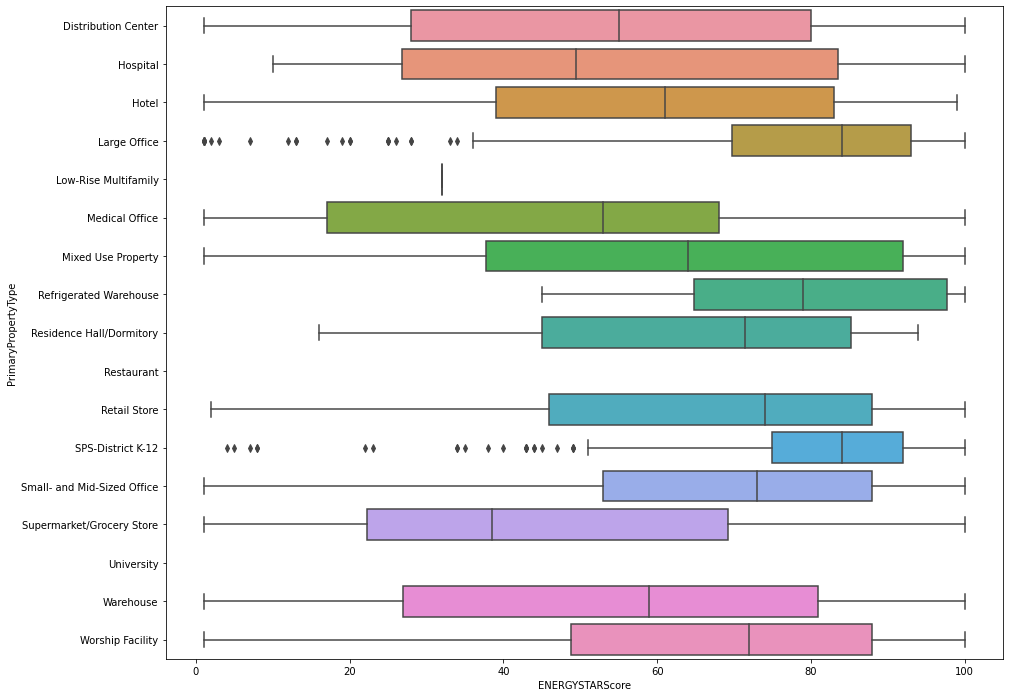

In [849]:
plt.figure(figsize=(15,12))
azerty = df[['ENERGYSTARScore', 'PrimaryPropertyType']].sort_values(by='PrimaryPropertyType')
sns.boxplot(y='PrimaryPropertyType', x='ENERGYSTARScore', data=azerty, orient='h')

In [850]:
df['BuildingAge']=df['DataYear']-df['YearBuilt']
df.drop(columns=['YearBuilt'],inplace=True)

<AxesSubplot:>

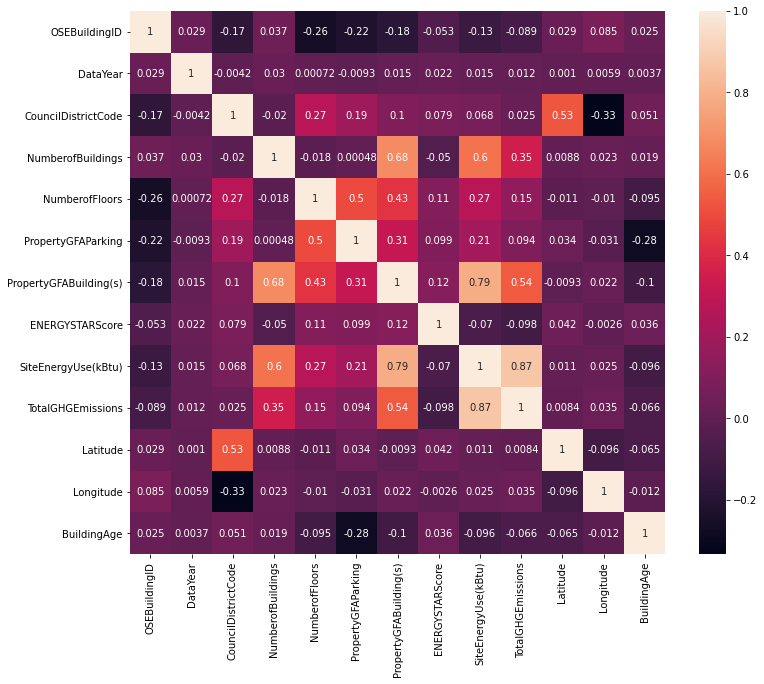

In [851]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

In [852]:
locationlist=[]
for index, row in df.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist.append([lat, long])

In [853]:
map = folium.Map(location=[df['Latitude'].median(), df['Longitude'].median()], zoom_start=12)
for point in range(0, len(df)):
    folium.CircleMarker(locationlist[point],radius=5).add_to(map)
map

In [854]:
a = df[['CouncilDistrictCode', 'Neighborhood']].groupby('CouncilDistrictCode')['Neighborhood'].apply(list)

In [855]:
def count_(list_code):
    dict_count={}
    items = set(list_code)
    for item in items :
        dict_count[item]=list_code.count(item)
    return dict_count
for i in range (1,8):
    print(count_(a[i]))

{'SOUTHWEST': 83, 'DELRIDGE': 92, 'GREATER DUWAMISH': 61}
{'GREATER DUWAMISH': 618, 'EAST': 2, 'DOWNTOWN': 87, 'SOUTHEAST': 84}
{'LAKE UNION': 30, 'DOWNTOWN': 21, 'CENTRAL': 110, 'GREATER DUWAMISH': 7, 'NORTHEAST': 2, 'EAST': 226, 'SOUTHEAST': 8}
{'NORTH': 4, 'NORTHEAST': 233, 'LAKE UNION': 95}
{'NORTH': 128, 'NORTHEAST': 8, 'NORTHWEST': 128}
{'NORTHWEST': 46, 'LAKE UNION': 44, 'BALLARD': 139}
{'EAST': 14, 'LAKE UNION': 127, 'DOWNTOWN': 620, 'MAGNOLIA / QUEEN ANNE': 301}


In [856]:
locationlist_2=[]
locationlist=[]
df_1=df[df['CouncilDistrictCode']==2]
df_2=df[df['CouncilDistrictCode']==3]
locationlist=[]
for index, row in df_1.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist.append([lat, long])
for index, row in df_2.iterrows():
    lat = row['Latitude']
    long=row['Longitude']
    locationlist_2.append([lat, long])
map = folium.Map(location=[df_1['Latitude'].median(), df_1['Longitude'].median()], zoom_start=12)
for point in range(0, len(df_1)):
    folium.CircleMarker(locationlist[point],radius=5, color='red').add_to(map)
for point in range(0, len(df_2)):
    folium.CircleMarker(locationlist_2[point],radius=5, color='blue').add_to(map)
map

In [857]:
# il semblerait que la variable CouncilDistrictCode ne soit pas pertinente -> on preferera encoder les quartiers

In [858]:
df.drop(columns=['CouncilDistrictCode'], inplace=True)

In [859]:
df['BuildingType'].unique()

array(['NonResidential', 'SPS-District K-12', 'Campus'], dtype=object)

In [860]:
numeric_columns= list(df.select_dtypes('float').columns) +list(df.select_dtypes('int').columns)
numeric_columns

['NumberofBuildings',
 'NumberofFloors',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'Latitude',
 'Longitude',
 'OSEBuildingID',
 'DataYear',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'BuildingAge']

In [861]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


for column in list(df.select_dtypes('O').columns):
    encoder=OneHotEncoder(sparse=False)
    cat_encoded = pd.DataFrame(encoder.fit_transform(df[[column]]))

    cat_encoded.columns = encoder.get_feature_names([column])
    df.reset_index(inplace=True, drop=True)
    df= pd.concat([df, cat_encoded], axis=1)
    df.drop(columns=[column], inplace=True)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [862]:
df.columns

Index(['OSEBuildingID', 'DataYear', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'TotalGHGEmissions', 'Latitude', 'Longitude',
       'BuildingAge', 'BuildingType_Campus', 'BuildingType_NonResidential',
       'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall/Dormitory',
       'PrimaryPropertyType_Restaurant', 'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_SPS-District K-12',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket/Grocery Store',
     

<AxesSubplot:>

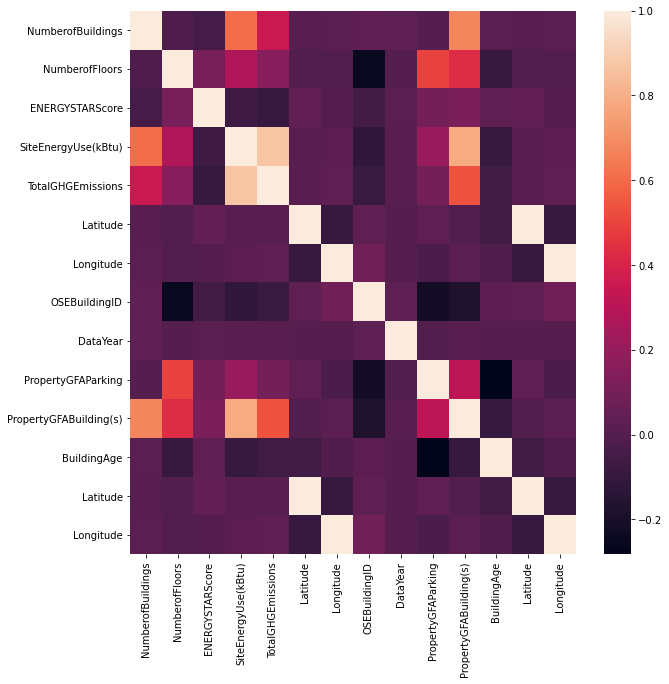

In [863]:
numeric_columns.append('Latitude')
numeric_columns.append('Longitude')
plt.figure(figsize=(10,10))
sns.heatmap(df[numeric_columns].corr())

<AxesSubplot:>

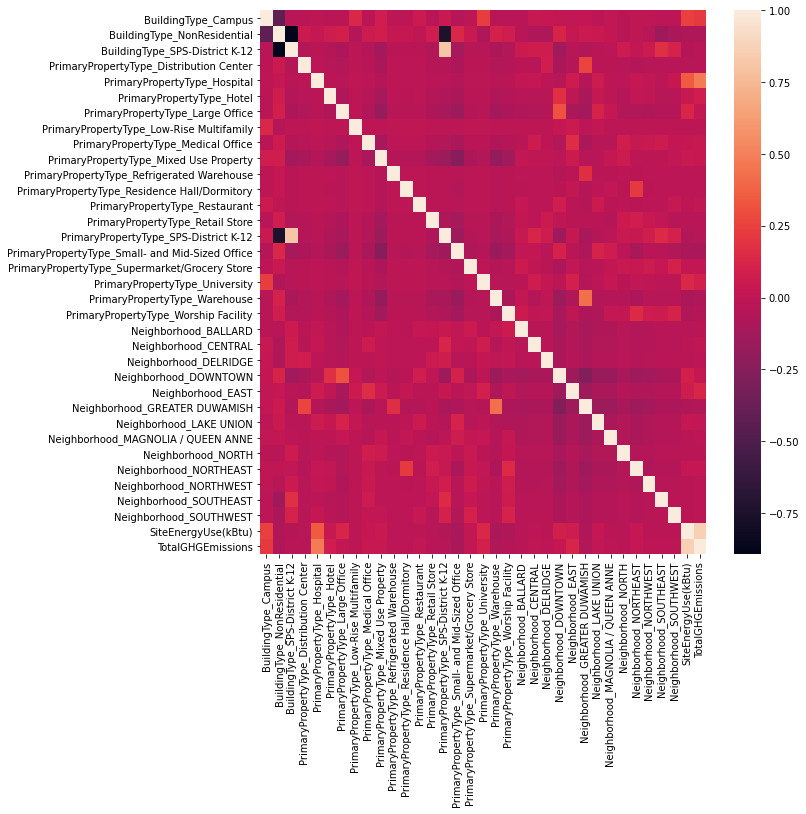

In [864]:
cat_col = [i for i in list(df.columns) if i not in numeric_columns]
cat_col.append('SiteEnergyUse(kBtu)')
cat_col.append('TotalGHGEmissions')
plt.figure(figsize=(10,10))
sns.heatmap(df[cat_col].corr())

# Normaliser les colonnes

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


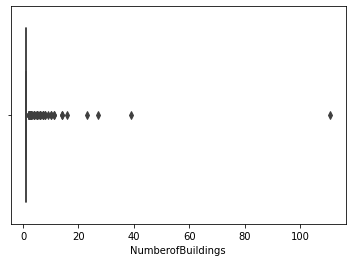

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


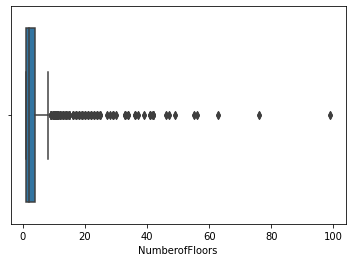

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


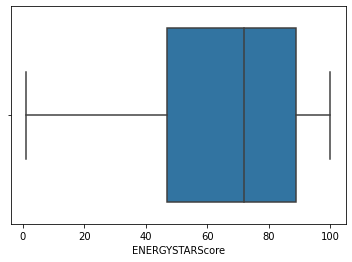

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


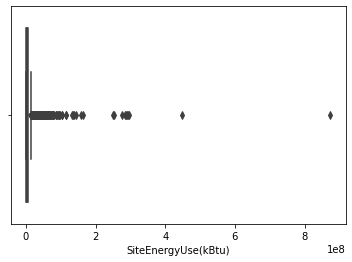

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


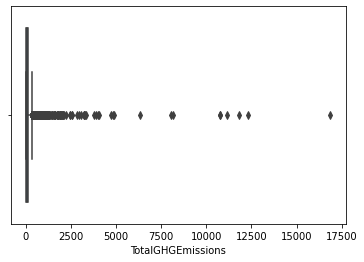

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


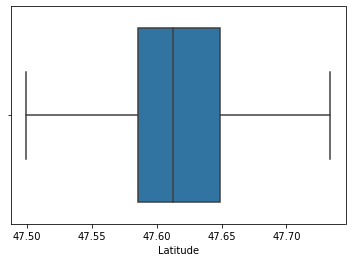

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


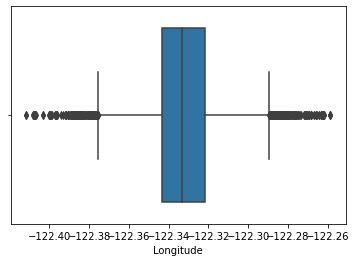

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


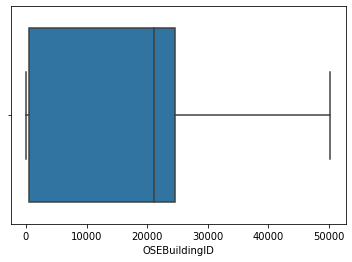

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


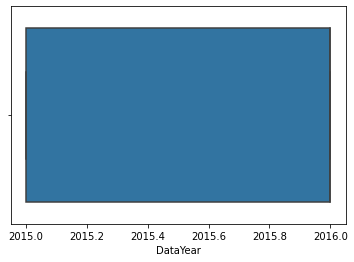

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


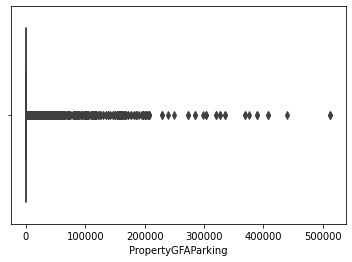

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


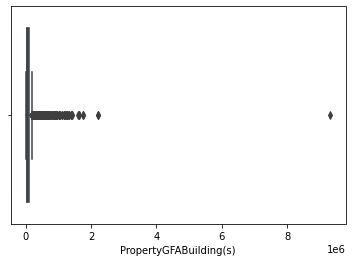

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


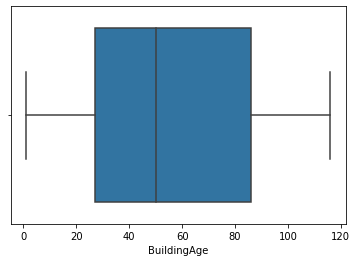

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


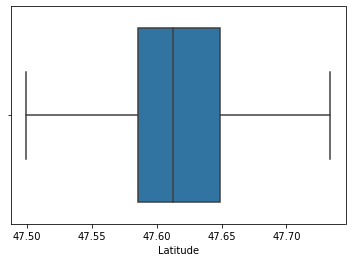

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


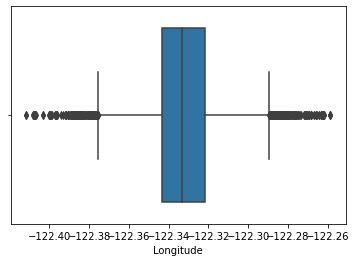

In [865]:
for column in numeric_columns :
    sns.boxplot(df[column])
    plt.show()

In [866]:
#je vais voir si j'enleve les données ou site energie use et total emission sont très élévées, j'obtiens de meilleures graphiques
'''q = df_['SiteEnergyUse(kBtu)'].quantile(0.99)
q
df_ = df_[df_['SiteEnergyUse(kBtu)']<q]'''

"q = df_['SiteEnergyUse(kBtu)'].quantile(0.99)\nq\ndf_ = df_[df_['SiteEnergyUse(kBtu)']<q]"

On peut voir pas mal d'outliers -> Robustscaler \
Pour les targets -> on veut normaliser la distrbution : boxcot ou log

In [867]:
to_robust = [
    'NumberofBuildings',
    'NumberofFloors',
    'ENERGYSTARScore',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'BuildingAge'
            ]
to_drop = ['Latitude',
             'Longitude',
          'OSEBuildingID',
          'DataYear']
targets=['SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',]

In [868]:

for column in to_robust:
    transformer = RobustScaler(unit_variance=True).fit(df[[column]])
    df[column] = transformer.transform(df[[column]])

In [869]:
df['NumberofBuildings'].value_counts()

0.000000      3252
1.348980        15
2.697959        14
5.395918         8
6.744898         6
4.046939         5
8.093877         4
9.442857         2
17.536734        2
12.140816        2
13.489795        2
35.073467        1
51.261221        1
10.791836        1
20.234693        1
29.677549        1
148.387745       1
Name: NumberofBuildings, dtype: int64

In [870]:
df['DataYear'] = df['DataYear'].map({2015:0, 2016:1})

In [871]:
df['DataYear'].unique()

array([0, 1])

# Site energy use prediction

## Fonctions

In [872]:
def grid_search(model, grid, scoring, X,y):
    search = GridSearchCV(model, grid,
                           scoring = scoring, n_jobs=-1)
    search.fit(X,y)
    return search.best_score_, search.best_params_, search.best_estimator_

In [873]:
def training(model, X, y, cv=5, scoring=scoring):
    res = cross_validate(model, X, y, cv = 5, scoring=scoring)
    scores = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
    }
    return scores

In [874]:
from sklearn.model_selection import learning_curve

def learning_curves(estimator, X, y, train_size, cv=5):
    '''Take :
    - estimator = model
    - X=data
    - y=target
    - train_size = range for testing (ex : [25,50,75,100,250,500,750,1000,1150, 2000, 3000]
    -cv = cross validation
    '''
    train_sizes, train_scores, test_scores= learning_curve(estimator=estimator, X=X, y=y, train_sizes=train_size, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, label = 'Cross val score')
    plt.ylabel('r2 score', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves', fontsize = 18, y = 1.03)
    plt.legend()

## Dernier ajustements

In [875]:
df_energy = df.copy()

In [876]:
df_energy=df_energy[df_energy['SiteEnergyUse(kBtu)']>0]
df_energy = df_energy[df_energy['SiteEnergyUse(kBtu)']<df_energy['SiteEnergyUse(kBtu)'].max()]
df_energy=df_energy.drop(columns=['Latitude', 'Longitude', 'OSEBuildingID'])

In [877]:
# https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203
def box_cot(df_series):
    # Python3 code to show Box-cox Transformation
    # of non-normal data

    # transform training data & save lambda value
    fitted_data, fitted_lambda = stats.boxcox(df_series)

    # creating axes to draw plots
    fig, ax = plt.subplots(1, 2)

    # plotting the original data(non-normal) and
    # fitted data (normal)
    sns.distplot(df_series, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
                 label = "Non-Normal", color ="green", ax = ax[0])

    sns.distplot(fitted_data, hist = False, kde = True,
    kde_kws = {'shade': True, 'linewidth': 2},
    label = "Normal", color ="green", ax = ax[1])

    # adding legends to the subplots
    plt.legend(loc = "upper right")

    # rescaling the subplots
    fig.set_figheight(5)
    fig.set_figwidth(10)
    plt.show();
    print(f"Lambda value used for Transformation: {fitted_lambda}")
    return fitted_data, fitted_lambda

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


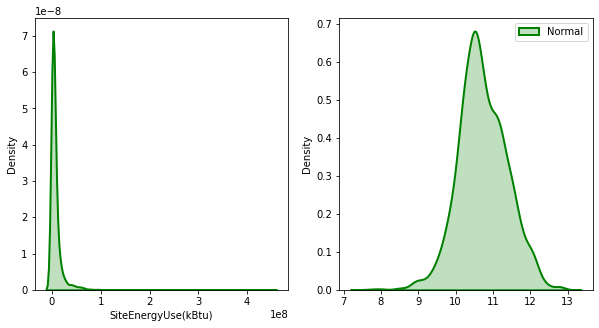

Lambda value used for Transformation: -0.046649614375230214


In [878]:
fitted_data, fitted_lambda = box_cot(df_energy['SiteEnergyUse(kBtu)'])

In [879]:
df_energy['energy_box_cox'] = fitted_data

In [880]:
# drop energystar score for my primary approch
df_energy_full = df_energy.copy()
df_energy = df_energy.drop(columns=['ENERGYSTARScore'])

## prepare X and y

In [881]:
X = df_energy.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y = df_energy['SiteEnergyUse(kBtu)']
y_boxcox = df_energy['energy_box_cox']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_box, X_test_box, y_train_box, y_test_box = train_test_split(X, y_boxcox, random_state=0)


In [882]:
y.median()

2537118.0

## Baseline

In [758]:
dummy_regr_mean = DummyRegressor(strategy="mean")
dummy_regr_median = DummyRegressor(strategy="median")

dummy_regr_mean.fit(X_train, y_train)
dummy_regr_median.fit(X_train, y_train)

y_predict_dummy_mean = dummy_regr_mean.predict(X_test)
y_predict_dummy_median = dummy_regr_median.predict(X_test)

In [759]:
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_median)))

  
print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, 
                                                                    y_predict_dummy_median)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))


Mean squared error (dummy): 297195893526199.69
Median absolute error (dummy): 1697720.38
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.09


## First models

In [609]:
from sklearn import metrics
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [610]:
#cv scoring
scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error']

### Linear regression

In [611]:
from sklearn.linear_model import LinearRegression
model = 'linear regression'

lr = LinearRegression()
lr_scores = training(lr, X, y)

print(f"score {model} : {lr_scores['time']}")
print(f"MAE {model} : {lr_scores['MAE']}")
print(f"RMSE {model} : {lr_scores['RMSE']}")
print(f"r2 {model} : {lr_scores['r2']}")

score linear regression : 0.02
MAE linear regression : -4739867.07
RMSE linear regression : -12982797.77
r2 linear regression : 0.48


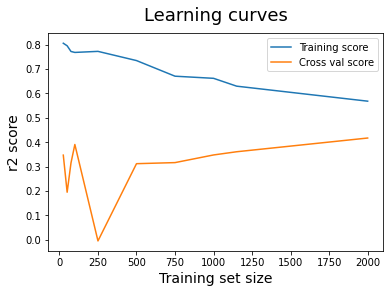

In [616]:
train_sizes = [25,50,75,100,250,500,750,1000,1150, 2000]
learning_curves(lr, X,y,train_sizes)

In [295]:
# Le modele n'a pas l'air d'overfitter mais je vais essayer un lasso /Ridge 
#pour voir si je peux augmenter les performances

In [617]:
#with target boxcox
lr = LinearRegression()
lr_scores_boxcox = training(lr, X, y_boxcox)

print(f"score {model} : {lr_scores_boxcox['time']}")
print(f"MAE {model} : {lr_scores_boxcox['MAE']}")
print(f"RMSE {model} : {lr_scores_boxcox['RMSE']}")
print(f"r2 {model} : {lr_scores_boxcox['r2']}")

score linear regression : 0.02
MAE linear regression : -0.37
RMSE linear regression : -0.48
r2 linear regression : 0.33


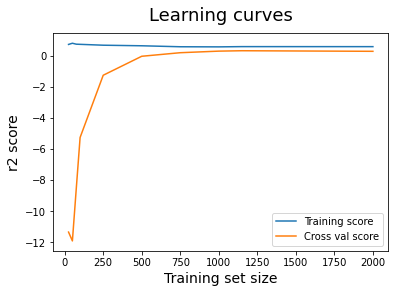

In [618]:
train_sizes = [25,50,75,100,250,500,750,1000,1150, 2000]
learning_curves(lr, X,y_boxcox,train_sizes)

### Ridge

In [619]:
from sklearn.linear_model import Ridge
model = Ridge()
grid = {'alpha': np.linspace(-1, 10, 30)}

best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
                      
print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -4689405.059969505,
 best_params : {'alpha': 10.0},
 best_estimator : Ridge(alpha=10.0)


In [622]:
model = Ridge(alpha=10)
ridge_scores = training(model, X, y)

print(f"score {model} : {ridge_scores['time']}")
print(f"MAE {model} : {ridge_scores['MAE']}")
print(f"RMSE {model} : {ridge_scores['RMSE']}")
print(f"r2 {model} : {ridge_scores['r2']}")

score Ridge(alpha=10) : 0.0
MAE Ridge(alpha=10) : -4689405.06
RMSE Ridge(alpha=10) : -13013677.17
r2 Ridge(alpha=10) : 0.48


In [625]:
#target boxcox
model = Ridge(alpha=10)
ridge_scores_box = training(model, X, y_boxcox)

print(f"score {model} : {ridge_scores_box['time']}")
print(f"MAE {model} : {ridge_scores_box['MAE']}")
print(f"RMSE {model} : {ridge_scores_box['RMSE']}")
print(f"r2 {model} : {ridge_scores_box['r2']}")

score Ridge(alpha=10) : 0.0
MAE Ridge(alpha=10) : -0.37
RMSE Ridge(alpha=10) : -0.48
r2 Ridge(alpha=10) : 0.32


### Lasso

In [626]:
from sklearn.linear_model import Lasso
model = Lasso()
grid = {'alpha': np.linspace(-1, 10, 30)}

best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
                      
print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -4739781.689187835,
 best_params : {'alpha': 10.0},
 best_estimator : Lasso(alpha=10.0)


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.736e+16, tolerance: 1.359e+14
  model = cd_fast.enet_coordinate_descent(


In [627]:
model = Lasso(alpha=10)
lasso_scores = training(model, X, y)

print(f"score {model} : {lasso_scores['time']}")
print(f"MAE {model} : {lasso_scores['MAE']}")
print(f"RMSE {model} : {lasso_scores['RMSE']}")
print(f"r2 {model} : {lasso_scores['r2']}")

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.928e+16, tolerance: 8.748e+13
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.225e+17, tolerance: 1.299e+14
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

score Lasso(alpha=10) : 0.11
MAE Lasso(alpha=10) : -4739781.69
RMSE Lasso(alpha=10) : -12982772.87
r2 Lasso(alpha=10) : 0.48


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e+16, tolerance: 1.269e+14
  model = cd_fast.enet_coordinate_descent(


In [628]:
#target boxcox
model = Lasso(alpha=10)
lasso_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {lasso_scores_boxcox['time']}")
print(f"MAE {model} : {lasso_scores_boxcox['MAE']}")
print(f"RMSE {model} : {lasso_scores_boxcox['RMSE']}")
print(f"r2 {model} : {lasso_scores_boxcox['r2']}")

score Lasso(alpha=10) : 0.0
MAE Lasso(alpha=10) : -0.49
RMSE Lasso(alpha=10) : -0.63
r2 Lasso(alpha=10) : -0.13


### KNN

In [629]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
grid = {'n_neighbors': np.arange(5,30)}

best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
                      
print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -4568769.996256884,
 best_params : {'n_neighbors': 5},
 best_estimator : KNeighborsRegressor()


In [630]:
model = KNeighborsRegressor(n_neighbors=5)
knn_scores = training(model, X, y)

print(f"score {model} : {knn_scores['time']}")
print(f"MAE {model} : {knn_scores['MAE']}")
print(f"RMSE {model} : {knn_scores['RMSE']}")
print(f"r2 {model} : {knn_scores['r2']}")

score KNeighborsRegressor() : 0.0
MAE KNeighborsRegressor() : -4568770.0
RMSE KNeighborsRegressor() : -13736836.03
r2 KNeighborsRegressor() : 0.46


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:4

In [631]:
#target boxcox
model = KNeighborsRegressor(n_neighbors=5)
knn_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {knn_scores_boxcox['time']}")
print(f"MAE {model} : {knn_scores_boxcox['MAE']}")
print(f"RMSE {model} : {knn_scores_boxcox['RMSE']}")
print(f"r2 {model} : {knn_scores_boxcox['r2']}")

score KNeighborsRegressor() : 0.0
MAE KNeighborsRegressor() : -0.31
RMSE KNeighborsRegressor() : -0.41
r2 KNeighborsRegressor() : 0.51


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/base.py:4

### Random Forest

In [632]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
grid = {'n_estimators': np.arange(10,200, 10), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(1,10),
       'max_depth':np.arange(1,10)}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

In [633]:
model = RandomForestRegressor(
    n_estimators= 150,
    min_samples_split=2,
    min_samples_leaf=1,)
randomforest_scores = training(model, X, y)

print(f"score {model} : {randomforest_scores['time']}")
print(f"MAE {model} : {randomforest_scores['MAE']}")
print(f"RMSE {model} : {randomforest_scores['RMSE']}")
print(f"r2 {model} : {randomforest_scores['r2']}")

score RandomForestRegressor(n_estimators=150) : 1.28
MAE RandomForestRegressor(n_estimators=150) : -2127965.42
RMSE RandomForestRegressor(n_estimators=150) : -7667756.05
r2 RandomForestRegressor(n_estimators=150) : 0.82


In [634]:
#boxcox
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
grid = {'n_estimators': np.arange(10,200, 10), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(1,10),
       'max_depth':np.arange(1,10)}

reboot =True #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y_boxcox)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')


best_score : -0.22683981717281995,
 best_params : {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 110},
 best_estimator : RandomForestRegressor(max_depth=9, n_estimators=110)


In [700]:
model = RandomForestRegressor()
randomforest_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {randomforest_scores_boxcox['time']}")
print(f"MAE {model} : {randomforest_scores_boxcox['MAE']}")
print(f"RMSE {model} : {randomforest_scores_boxcox['RMSE']}")
print(f"r2 {model} : {randomforest_scores_boxcox['r2']}")

score RandomForestRegressor() : 0.78
MAE RandomForestRegressor() : -0.49
RMSE RandomForestRegressor() : -0.69
r2 RandomForestRegressor() : 0.79


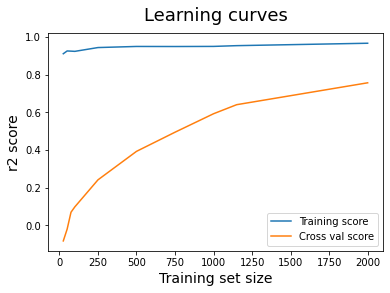

In [636]:
learning_curves(model, X, y_boxcox, train_sizes)

### XGBOOST

In [637]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
grid = {'n_estimators': np.arange(40,200, 20), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(2,10)}

reboot =True #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

best_score : -2955080.019063142,
 best_params : {'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 180},
 best_estimator : GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180)


In [638]:
model = GradientBoostingRegressor(
    n_estimators= 180,
    min_samples_split=2,
    min_samples_leaf=2,)
XGBOST_scores = training(model, X, y)

print(f"score {model} : {XGBOST_scores['time']}")
print(f"MAE {model} : {XGBOST_scores['MAE']}")
print(f"RMSE {model} : {XGBOST_scores['RMSE']}")
print(f"r2 {model} : {XGBOST_scores['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.35
MAE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -2956623.21
RMSE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -8202803.75
r2 GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.79


In [883]:
#target boxcot
model = GradientBoostingRegressor(
    n_estimators= 180,
    min_samples_split=2,
    min_samples_leaf=2,)
XGBOST_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {XGBOST_scores_boxcox['time']}")
print(f"MAE {model} : {XGBOST_scores_boxcox['MAE']}")
print(f"RMSE {model} : {XGBOST_scores_boxcox['RMSE']}")
print(f"r2 {model} : {XGBOST_scores_boxcox['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.35
MAE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.24
RMSE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.34
r2 GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.66


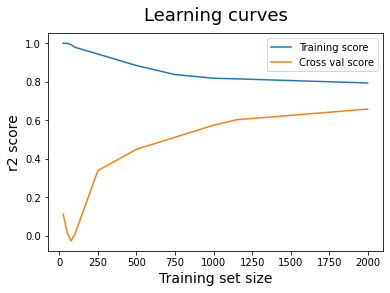

In [884]:
learning_curves(model, X, y_boxcox, train_sizes)

### Analyse

In [640]:
lr_scores

{'time': 0.02, 'MAE': -4739867.07, 'RMSE': -12982797.77, 'r2': 0.48}

In [641]:
scores = pd.DataFrame([lr_scores,
         ridge_scores,
         knn_scores,
         randomforest_scores, 
        XGBOST_scores], index=['lr', 'ridge', 'knn', 'randomforest', 'XGBOOST'])
scores['MAE']=scores['MAE']*-1
scores['RMSE']=scores['RMSE']*-1
scores

time         MAE         RMSE    r2
lr            0.02  4739867.07  12982797.77  0.48
ridge         0.00  4689405.06  13013677.17  0.48
knn           0.00  4568770.00  13736836.03  0.46
randomforest  1.28  2127965.42   7667756.05  0.82
XGBOOST       0.35  2956623.21   8202803.75  0.79

In [642]:
scores_box = pd.DataFrame([lr_scores_boxcox,
         ridge_scores_box,
         knn_scores_boxcox,
         randomforest_scores_boxcox, 
        XGBOST_scores_boxcox], index=['lr', 'ridge', 'knn', 'randomforest', 'XGBOOST'])
scores_box['MAE']=scores_box['MAE']*-1
scores_box['RMSE']=scores_box['RMSE']*-1
scores_box

time   MAE  RMSE    r2
lr            0.02  0.37  0.48  0.33
ridge         0.00  0.37  0.48  0.32
knn           0.00  0.31  0.41  0.51
randomforest  0.80  0.16  0.24  0.84
XGBOOST       0.35  0.24  0.34  0.66

Text(0.5, 1.0, 'MAE')

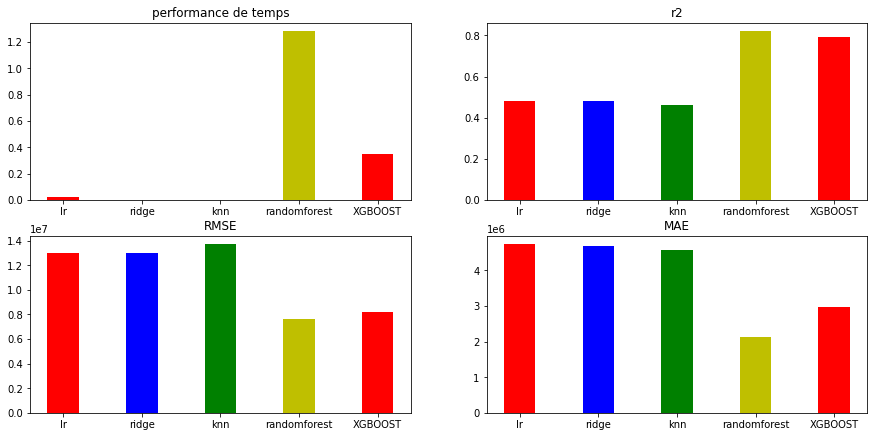

In [643]:
#Comparaison :
plt.figure(figsize=(15,15))
plt.subplot(421)
plt.bar(x=scores.index, height=list(scores['time']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('performance de temps')
plt.subplot(422)
plt.bar(x=scores.index, height=list(scores['r2']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('r2')
plt.subplot(423)
plt.bar(x=scores.index, height=list(scores['RMSE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('RMSE')
plt.subplot(424)
plt.bar(x=scores.index, height=list(scores['MAE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('MAE')

Text(0.5, 1.0, 'MAE boxcox')

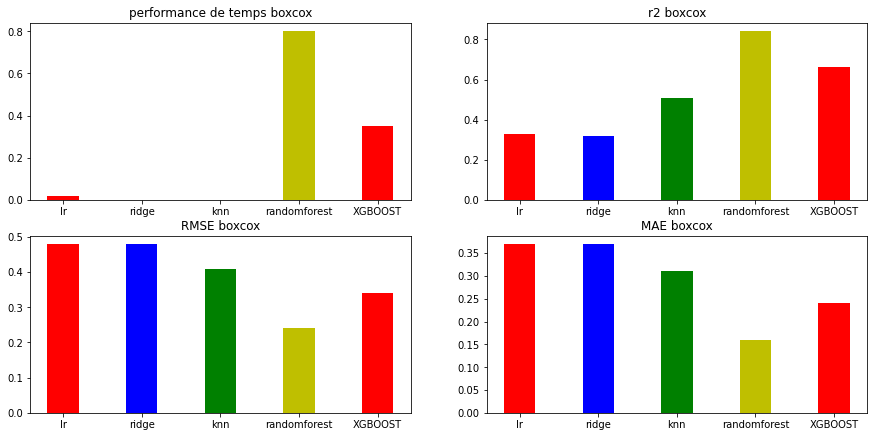

In [644]:
#Comparaison :
plt.figure(figsize=(15,15))
plt.subplot(421)
plt.bar(x=scores_box.index, height=list(scores_box['time']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('performance de temps boxcox')
plt.subplot(422)
plt.bar(x=scores_box.index, height=list(scores_box['r2']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('r2 boxcox')
plt.subplot(423)
plt.bar(x=scores_box.index, height=list(scores_box['RMSE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('RMSE boxcox')
plt.subplot(424)
plt.bar(x=scores_box.index, height=list(scores_box['MAE']), width=0.4, color=['r', 'b', 'g', 'y'])
plt.title('MAE boxcox')

On constate que le modele random forest et XGBOOST sont les deux modeles qui dominent

## Entrainement Random Forest

In [645]:
model = RandomForestRegressor(
    n_estimators= 140,
    min_samples_split=2,
    min_samples_leaf=1)
#fit
model.fit(X_train, y_train)
#pred
prediction = model.predict(X_test)
#features importances
model.feature_importances_.reshape(1,-1).shape

(1, 39)

In [646]:
#boxcox
model_box = RandomForestRegressor(
    n_estimators= 140,
    min_samples_split=2,
    min_samples_leaf=1)
#fit
model_box.fit(X_train_box, y_train_box)
#pred
prediction_box = model_box.predict(X_test_box)
#features importances
model_box.feature_importances_.reshape(1,-1).shape

(1, 39)

## Analyse

Text(0.5, 1.0, 'features importances sans boxcot')

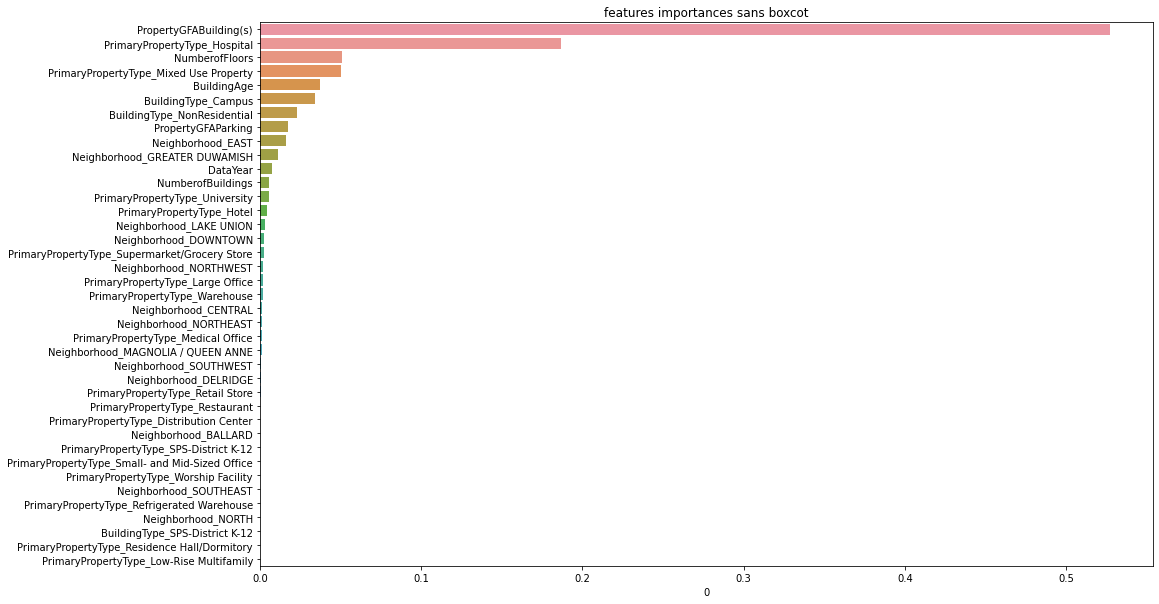

In [647]:
plt.figure(figsize=(16,10))
features = pd.DataFrame(model.feature_importances_.reshape(1,-1), columns=X_train.columns)
features=features.T
features=features.sort_values(by=0, ascending=False)
sns.barplot(x=features[0], y=list(features.index))
plt.title('features importances sans boxcot')

Text(0.5, 1.0, 'features importances avec boxcot')

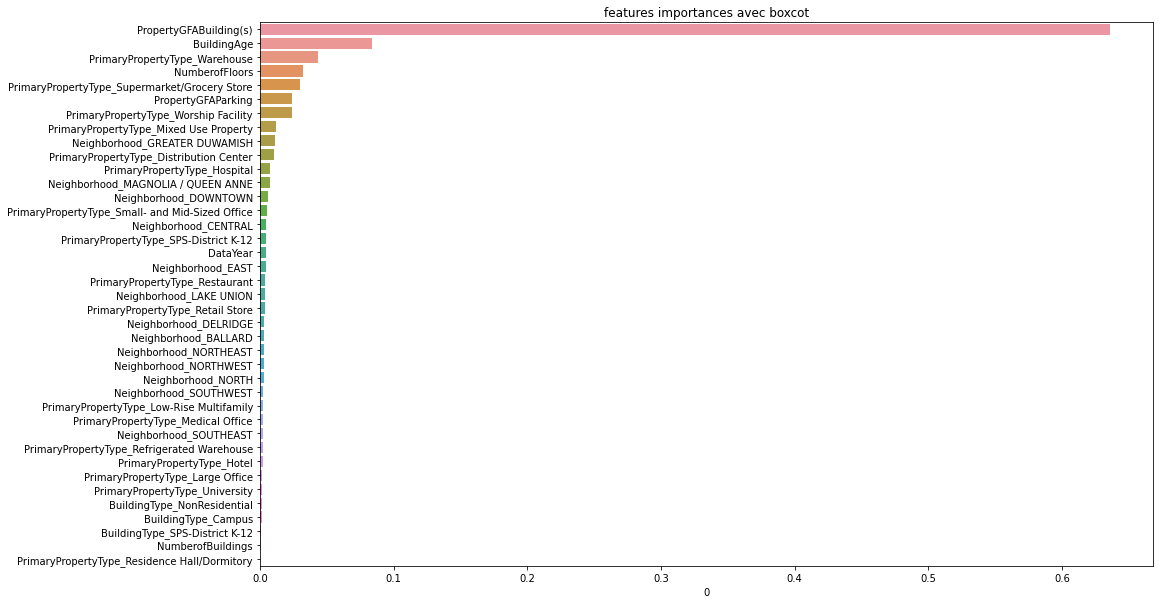

In [648]:
plt.figure(figsize=(16,10))
features = pd.DataFrame(model_box.feature_importances_.reshape(1,-1), columns=X_train_box.columns)
features=features.T
features=features.sort_values(by=0, ascending=False)
sns.barplot(x=features[0], y=list(features.index))
plt.title('features importances avec boxcot')

In [650]:
predictions = pd.DataFrame({'pred': prediction, 'pred_box': prediction_box})
df_test=pd.concat([X_test, y_test], axis=1)
df_test=pd.concat([df_test, y_test_box], axis=1)
df_test.reset_index(drop=True, inplace=True)
df_test=pd.concat([df_test, predictions], axis=1, )

In [651]:
df_test.head()

DataYear  NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0         0                0.0         0.44966         35936.81389   
1         0                0.0         0.44966             0.00000   
2         1                0.0         0.44966             0.00000   
3         0                0.0        -0.44966             0.00000   
4         1                0.0        -0.44966             0.00000   

   PropertyGFABuilding(s)  BuildingAge  BuildingType_Campus  \
0               -0.205453    -0.320097                  0.0   
1               -0.316962     1.006019                  0.0   
2               -0.494129    -0.983155                  0.0   
3               -0.531387     1.486164                  0.0   
4                0.028593     0.937426                  0.0   

   BuildingType_NonResidential  BuildingType_SPS-District K-12  \
0                          1.0                             0.0   
1                          1.0                             0.0   
2                          1.0                             0.0   
3                          1.0                             0.0   
4                          0.0                             1.0   

   PrimaryPropertyType_Distribution Center  ...  \
0                                      0.0  ...   
1                                      0.0  ...   
2                                      0.0  ...   
3                                      0.0  ...   
4                                      0.0  ...   

   Neighborhood_MAGNOLIA / QUEEN ANNE  Neighborhood_NORTH  \
0                                 0.0                 0.0   
1                                 0.0                 0.0   
2                                 1.0                 0.0   
3                                 0.0                 0.0   
4                                 1.0                 0.0   

   Neighborhood_NORTHEAST  Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  \
0                     0.0                     0.0                     0.0   
1                     0.0                     0.0                     0.0   
2                     0.0                     0.0                     0.0   
3                     0.0                     0.0                     0.0   
4                     0.0                     0.0                     0.0   

   Neighborhood_SOUTHWEST  SiteEnergyUse(kBtu)  energy_box_cox          pred  \
0                     0.0          2513155.000       10.657263  2.329353e+06   
1                     0.0          2433777.000       10.641112  2.197817e+06   
2                     0.0           739210.500       10.024026  1.014210e+06   
3                     0.0           869835.000       10.110328  2.258753e+06   
4                     0.0          1298307.625       10.319977  1.712765e+06   

    pred_box  
0  10.608141  
1  10.532682  
2   9.873058  
3  10.168059  
4  10.406308  

[5 rows x 43 columns]

In [652]:
df_test['pred_box']=df_test['pred_box'].apply(lambda x : inv_boxcox(x, fitted_lambda))

In [653]:
median_absolute_error(list(df_test['SiteEnergyUse(kBtu)']), df_test['pred_box'])

622358.9317287775

In [654]:
df_test['diff_pred_truth']=abs(df_test['SiteEnergyUse(kBtu)']-df_test['pred'])
df_test['diff_pred_truth_box']=abs(df_test['SiteEnergyUse(kBtu)']-df_test['pred_box'])

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


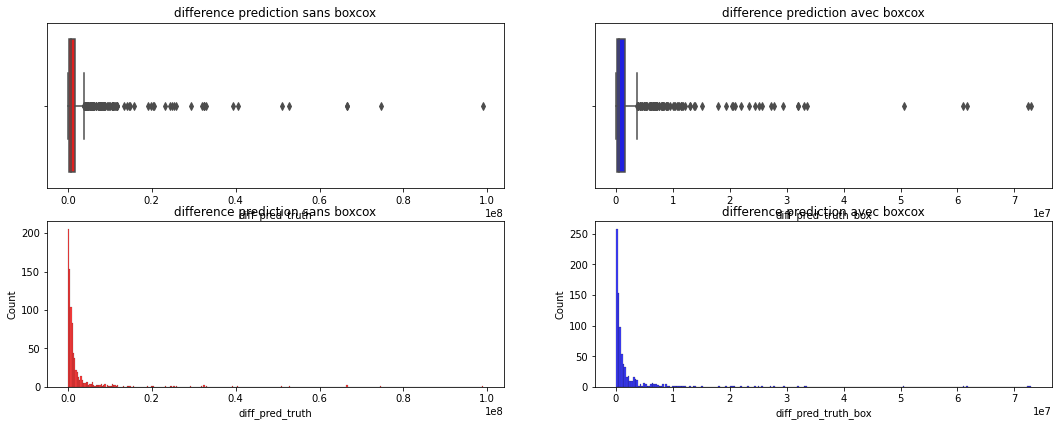

In [655]:
plt.figure(figsize=(18,14))
plt.subplot(421)
sns.boxplot(df_test['diff_pred_truth'], color='r')
plt.title('difference prediction sans boxcox')
plt.subplot(422)
sns.boxplot(df_test['diff_pred_truth_box'], color='b')
plt.title('difference prediction avec boxcox')
plt.subplot(423)
sns.histplot(df_test['diff_pred_truth'], color='r')
plt.title('difference prediction sans boxcox')
plt.subplot(424)
sns.histplot(df_test['diff_pred_truth_box'], color='b')
plt.title('difference prediction avec boxcox');

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SiteEnergyUse(kBtu)'>

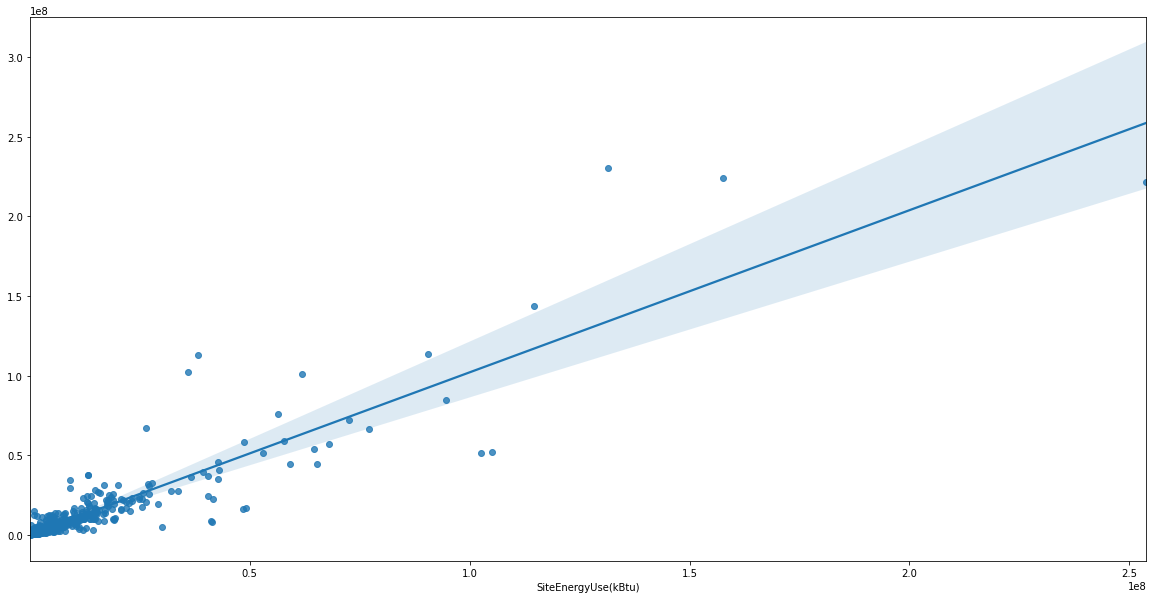

In [656]:
plt.figure(figsize=(20,10))
sns.regplot(y_test, prediction)

In [657]:
df_test[df_test['diff_pred_truth_box']==df_test['diff_pred_truth_box'].max()]

DataYear  NumberofBuildings  NumberofFloors  PropertyGFAParking  \
416         1                0.0         1.34898                 0.0   

     PropertyGFABuilding(s)  BuildingAge  BuildingType_Campus  \
416                9.996039    -0.708786                  1.0   

     BuildingType_NonResidential  BuildingType_SPS-District K-12  \
416                          0.0                             0.0   

     PrimaryPropertyType_Distribution Center  ...  Neighborhood_NORTHEAST  \
416                                      0.0  ...                     0.0   

     Neighborhood_NORTHWEST  Neighborhood_SOUTHEAST  Neighborhood_SOUTHWEST  \
416                     0.0                     0.0                     0.0   

     SiteEnergyUse(kBtu)  energy_box_cox          pred      pred_box  \
416          131373880.0       12.473957  2.303679e+08  5.848336e+07   

     diff_pred_truth  diff_pred_truth_box  
416     9.899398e+07         7.289052e+07  

[1 rows x 45 columns]

## Test améliorations 

### : remove columns with low interest

In [658]:
# Drop features peu impactantes
df_energy_features = df_energy.drop(columns=list(features.index[:28]))

In [659]:
X_features = df_energy_features.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y_features = df_energy_features['SiteEnergyUse(kBtu)']


In [660]:
model = RandomForestRegressor()
res = cross_validate(model, X_features, y_features, cv = 5, scoring=scoring)

randomforest_scores_f = {
    'time': round(res['fit_time'].mean(),2), 
    'MAE' : round(res['test_neg_mean_absolute_error'].mean(), 2), 
    'RMSE' : round(res['test_neg_root_mean_squared_error'].mean(),2),
    'r2': round(res['test_r2'].mean(),2)
}

print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")

score RandomForestRegressor() : 0.11
MAE RandomForestRegressor() : -7507559.42
RMSE RandomForestRegressor() : -19059811.51
r2 RandomForestRegressor() : -0.21


In [661]:
randomforest_scores_f

{'time': 0.11, 'MAE': -7507559.42, 'RMSE': -19059811.51, 'r2': -0.21}

In [662]:
# Clairement nul !

### Remove outliers

In [663]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.15)
    q3 = df_in[col_name].quantile(0.85)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [664]:
df_energy_without_outliers = remove_outlier(df_energy, 'SiteEnergyUse(kBtu)')
len(df_energy_without_outliers)/len(df_energy)

0.9477203647416413

<AxesSubplot:xlabel='boxcox_emission', ylabel='Count'>

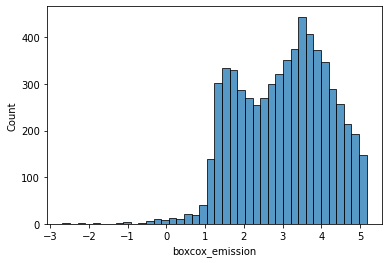

In [665]:
sns.histplot(y_outliers_box)

In [666]:
X_outliers = df_energy_without_outliers.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y_outliers = df_energy_without_outliers['SiteEnergyUse(kBtu)']
y_outliers_box=df_energy_without_outliers['energy_box_cox']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_outliers, y_outliers )
randomforest_scores_f_box = training(model_box, X_outliers, y_outliers_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_f_box['time']}")
print(f"MAE {model} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.78
MAE RandomForestRegressor() : -1114705.54
RMSE RandomForestRegressor() : -1948074.05
r2 RandomForestRegressor() : 0.83
______
score RandomForestRegressor() : 0.74
MAE RandomForestRegressor() : -0.15
RMSE RandomForestRegressor() : -0.23
r2 RandomForestRegressor() : 0.81


In [667]:
# Permet d'obternir les meilleurs résultats sans gridsearch !

## EnergyStarScore impact?

In [668]:
df_energy_full.isnull().sum()

DataYear                                              0
NumberofBuildings                                     0
NumberofFloors                                        0
PropertyGFAParking                                    0
PropertyGFABuilding(s)                                0
ENERGYSTARScore                                    1080
SiteEnergyUse(kBtu)                                   0
TotalGHGEmissions                                     0
BuildingAge                                           0
BuildingType_Campus                                   0
BuildingType_NonResidential                           0
BuildingType_SPS-District K-12                        0
PrimaryPropertyType_Distribution Center               0
PrimaryPropertyType_Hospital                          0
PrimaryPropertyType_Hotel                             0
PrimaryPropertyType_Large Office                      0
PrimaryPropertyType_Low-Rise Multifamily              0
PrimaryPropertyType_Medical Office              

In [669]:
df_energy_full=df_energy_full[~df_energy_full['ENERGYSTARScore'].isna()]
X_stars = df_energy_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'energy_box_cox'])
y_stars = df_energy_full['SiteEnergyUse(kBtu)']
y_stars_box = df_energy_full['energy_box_cox']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_stars, y_stars )
randomforest_scores_f_box = training(model_box, X_stars, y_stars_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_f_box['time']}")
print(f"MAE {model} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.64
MAE RandomForestRegressor() : -2017884.61
RMSE RandomForestRegressor() : -10035935.66
r2 RandomForestRegressor() : 0.77
______
score RandomForestRegressor() : 0.58
MAE RandomForestRegressor() : -0.11
RMSE RandomForestRegressor() : -0.18
r2 RandomForestRegressor() : 0.9


In [670]:
X_without_stars = df_energy_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'ENERGYSTARScore','energy_box_cox' ])
y_without_stars = df_energy_full['SiteEnergyUse(kBtu)']
y_without_stars_box = df_energy_full['energy_box_cox']


model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_without_stars, y_without_stars )
randomforest_scores_f_box = training(model_box, X_without_stars, y_without_stars_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model} : {randomforest_scores_f_box['time']}")
print(f"MAE {model} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.57
MAE RandomForestRegressor() : -2042364.55
RMSE RandomForestRegressor() : -9027118.04
r2 RandomForestRegressor() : 0.81
______
score RandomForestRegressor() : 0.51
MAE RandomForestRegressor() : -0.13
RMSE RandomForestRegressor() : -0.21
r2 RandomForestRegressor() : 0.86


In [671]:
#l'EnergieStarScore semble aveoir un impact APRES boxcox 🧐

# Emission 

In [766]:
df_emission = df.copy(deep=True)

## Derniers ajustements

In [767]:
df_emission=df_emission[df_emission['TotalGHGEmissions']>0]

<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Count'>

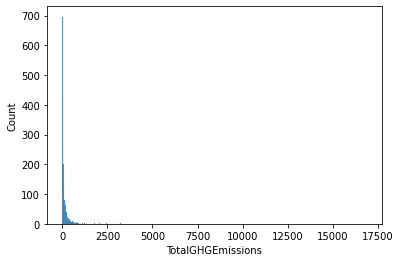

In [768]:
sns.histplot(df_emission['TotalGHGEmissions'])

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


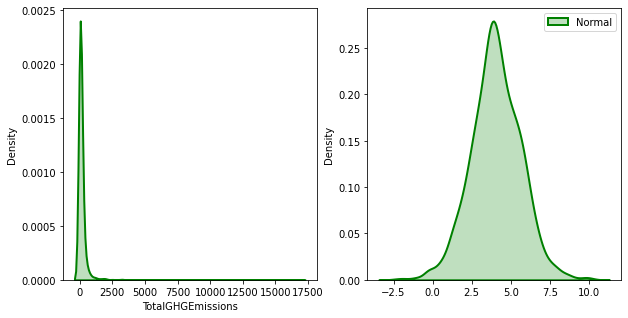

Lambda value used for Transformation: 0.012729962251216375


In [769]:
fitted_data, fitted_lambda = box_cot(df_emission['TotalGHGEmissions'])
df_emission['boxcox_emission']=fitted_data

<AxesSubplot:xlabel='boxcox_emission', ylabel='Count'>

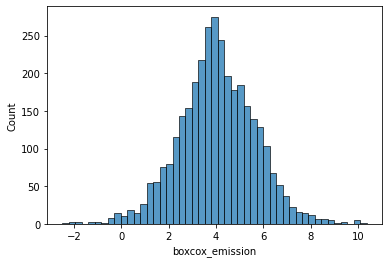

In [770]:
sns.histplot(df_emission['boxcox_emission'])

In [771]:
df_emission=df_emission.drop(columns=['Latitude', 'Longitude', 'OSEBuildingID'])

In [772]:
# drop energystar score for my primary approch
df_emission_full = df_emission.copy()
df_emission = df_emission_full.drop(columns=['ENERGYSTARScore'])

## Prepare X & y

In [773]:
X = df_emission.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission'])
y = df_emission['TotalGHGEmissions']
y_boxcox = df_emission['boxcox_emission']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train_box, X_test_box, y_train_box, y_test_box = train_test_split(X, y_boxcox, random_state=0)

## Baseline

In [774]:
dummy_regr_mean = DummyRegressor(strategy="mean")
dummy_regr_median = DummyRegressor(strategy="median")

dummy_regr_mean.fit(X_train, y_train)
dummy_regr_median.fit(X_train, y_train)

y_predict_dummy_mean = dummy_regr_mean.predict(X_test)
y_predict_dummy_median = dummy_regr_median.predict(X_test)

In [780]:
y.median()

49.254999999999995

In [779]:
print("Mean squared error (dummy): {:.2f}".format(mean_squared_error(y_test, 
                                                                     y_predict_dummy_mean)))

  
print("Median absolute error (dummy): {:.2f}".format(median_absolute_error(y_test, 
                                                                    y_predict_dummy_median)))
  
print("r2_score (dummy mean): {:.2f}".format(r2_score(y_test, y_predict_dummy_mean)))
print("r2_score (dummy median): {:.2f}".format(r2_score(y_test, y_predict_dummy_median)))


Mean squared error (dummy): 363897.59
Median absolute error (dummy): 39.04
r2_score (dummy mean): -0.00
r2_score (dummy median): -0.04


## models evaluation :

### Linear Reg

In [682]:
from sklearn.linear_model import LinearRegression
model = 'linear regression'

lr = LinearRegression()
lr_scores = training(lr, X, y)

print(f"score {model} : {lr_scores['time']}")
print(f"MAE {model} : {lr_scores['MAE']}")
print(f"RMSE {model} : {lr_scores['RMSE']}")
print(f"r2 {model} : {lr_scores['r2']}")

score linear regression : 0.02
MAE linear regression : -159.12
RMSE linear regression : -454.16
r2 linear regression : 0.46


In [683]:
from sklearn.linear_model import LinearRegression
model = 'linear regression'

lr = LinearRegression()
lr_scores_box = training(lr, X, y_boxcox)

print(f"score {model} : {lr_scores_box['time']}")
print(f"MAE {model} : {lr_scores_box['MAE']}")
print(f"RMSE {model} : {lr_scores_box['RMSE']}")
print(f"r2 {model} : {lr_scores_box['r2']}")

score linear regression : 0.02
MAE linear regression : -1.01
RMSE linear regression : -1.35
r2 linear regression : 0.2


### Random Forest

In [684]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
grid = {'n_estimators': np.arange(10,200, 10), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(1,10),
       'max_depth':np.arange(1,10)}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

In [685]:
model = RandomForestRegressor()
randomforest_scores = training(model, X, y)

print(f"score {model} : {randomforest_scores['time']}")
print(f"MAE {model} : {randomforest_scores['MAE']}")
print(f"RMSE {model} : {randomforest_scores['RMSE']}")
print(f"r2 {model} : {randomforest_scores['r2']}")

score RandomForestRegressor() : 0.92
MAE RandomForestRegressor() : -68.58
RMSE RandomForestRegressor() : -313.08
r2 RandomForestRegressor() : 0.74


In [686]:
model = RandomForestRegressor()
randomforest_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {randomforest_scores_boxcox['time']}")
print(f"MAE {model} : {randomforest_scores_boxcox['MAE']}")
print(f"RMSE {model} : {randomforest_scores_boxcox['RMSE']}")
print(f"r2 {model} : {randomforest_scores_boxcox['r2']}")

score RandomForestRegressor() : 0.79
MAE RandomForestRegressor() : -0.48
RMSE RandomForestRegressor() : -0.68
r2 RandomForestRegressor() : 0.79


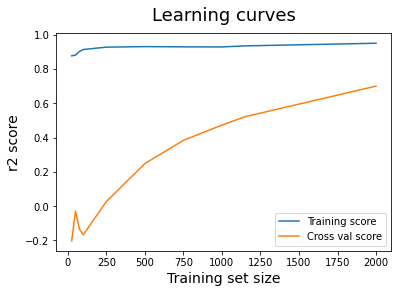

In [687]:
learning_curves(model, X, y_boxcox, train_sizes)

### XGBOOST

In [688]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
grid = {'n_estimators': np.arange(40,200, 20), 
        'min_samples_split':np.arange(2,10),
       'min_samples_leaf':np.arange(2,10)}

reboot =False #mettre à True pour relancer gridsearch
if reboot :
    best_score,best_params,best_estimator= search = grid_search(model, grid, 'neg_mean_absolute_error', X,y)
    print(f'best_score : {best_score},\n best_params : {best_params},\n best_estimator : {best_estimator}')

In [689]:
model = GradientBoostingRegressor()
XGBOST_scores = training(model, X, y)

print(f"score {model} : {XGBOST_scores['time']}")
print(f"MAE {model} : {XGBOST_scores['MAE']}")
print(f"RMSE {model} : {XGBOST_scores['RMSE']}")
print(f"r2 {model} : {XGBOST_scores['r2']}")

score GradientBoostingRegressor() : 0.2
MAE GradientBoostingRegressor() : -93.2
RMSE GradientBoostingRegressor() : -316.07
r2 GradientBoostingRegressor() : 0.72


In [690]:
#target boxcot
model = GradientBoostingRegressor(
    n_estimators= 180,
    min_samples_split=2,
    min_samples_leaf=2,)
XGBOST_scores_boxcox = training(model, X, y_boxcox)

print(f"score {model} : {XGBOST_scores_boxcox['time']}")
print(f"MAE {model} : {XGBOST_scores_boxcox['MAE']}")
print(f"RMSE {model} : {XGBOST_scores_boxcox['RMSE']}")
print(f"r2 {model} : {XGBOST_scores_boxcox['r2']}")

score GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.35
MAE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -0.76
RMSE GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : -1.0
r2 GradientBoostingRegressor(min_samples_leaf=2, n_estimators=180) : 0.55


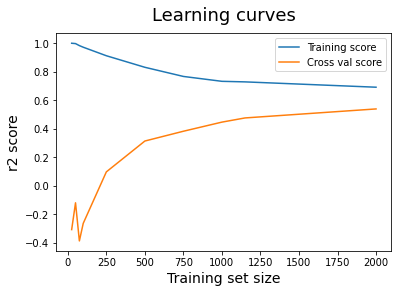

In [691]:
learning_curves(model, X, y_boxcox, train_sizes)

In [692]:
scores = pd.DataFrame([lr_scores,
         randomforest_scores, 
        XGBOST_scores], index=['lr','randomforest', 'XGBOOST'])
scores['MAE']=scores['MAE']*-1
scores['RMSE']=scores['RMSE']*-1
scores_box = pd.DataFrame([lr_scores_boxcox,
         randomforest_scores_boxcox, 
        XGBOST_scores_boxcox], index=['lr', 'randomforest', 'XGBOOST'])
scores_box['MAE']=scores_box['MAE']*-1
scores_box['RMSE']=scores_box['RMSE']*-1
scores_box

time   MAE  RMSE    r2
lr            0.02  0.37  0.48  0.33
randomforest  0.79  0.48  0.68  0.79
XGBOOST       0.35  0.76  1.00  0.55

In [693]:
scores

time     MAE    RMSE    r2
lr            0.02  159.12  454.16  0.46
randomforest  0.92   68.58  313.08  0.74
XGBOOST       0.20   93.20  316.07  0.72

## remove outliers ?

In [694]:
df_emission_without_outliers = remove_outlier(df_emission, 'TotalGHGEmissions')
len(df_emission_without_outliers)/len(df_emission)

0.9524242424242424

In [695]:
#comparaison des outliers energy <-> emission
len(df_energy_without_outliers[df_energy_without_outliers.index.isin(
    list(df_emission_without_outliers.index) )])/len(df_energy_without_outliers)

0.9852469531751122

In [696]:
df_emission_without_outliers

DataYear  NumberofBuildings  NumberofFloors  PropertyGFAParking  \
0            0                0.0        4.496598            0.000000   
1            0                0.0        4.046939        20321.027194   
4            0                0.0        7.194557        16808.284575   
5            0                0.0        0.000000        50179.339456   
6            0                0.0        4.046939            0.000000   
...        ...                ...             ...                 ...   
3313         1                0.0       -0.449660            0.000000   
3314         1                0.0       -0.449660            0.000000   
3315         1                0.0       -0.449660            0.000000   
3316         1                0.0       -0.449660            0.000000   
3317         1                0.0       -0.449660            0.000000   

      PropertyGFABuilding(s)  SiteEnergyUse(kBtu)  TotalGHGEmissions  \
0                   0.839746         6.981428e+06             249.43   
1                   0.841137         8.354235e+06             263.51   
4                   1.228412         1.482910e+07             507.70   
5                   0.259816         1.205198e+07             304.62   
6                   0.728728         6.252842e+06             208.46   
...                      ...                  ...                ...   
3313               -0.718109         8.497457e+05              20.94   
3314               -0.642283         9.502762e+05              32.17   
3315               -0.700451         5.765898e+06             223.54   
3316               -0.681137         7.194712e+05              22.11   
3317               -0.596083         1.152896e+06              41.27   

      BuildingAge  BuildingType_Campus  BuildingType_NonResidential  ...  \
0        0.868834                  0.0                          1.0  ...   
1       -0.708786                  0.0                          1.0  ...   
4       -0.342961                  0.0                          1.0  ...   
5       -0.777378                  0.0                          1.0  ...   
6        0.891698                  0.0                          1.0  ...   
...           ...                  ...                          ...  ...   
3313    -0.548737                  0.0                          1.0  ...   
3314    -0.868834                  0.0                          1.0  ...   
3315    -0.182912                  0.0                          1.0  ...   
3316    -0.525873                  0.0                          1.0  ...   
3317     0.640194                  0.0                          1.0  ...   

      Neighborhood_EAST  Neighborhood_GREATER DUWAMISH  \
0                   0.0                            0.0   
1                   0.0                            0.0   
4                   0.0                            0.0   
5                   0.0                            0.0   
6                   0.0                            0.0   
...                 ...                            ...   
3313                0.0                            1.0   
3314                0.0                            0.0   
3315                0.0                            0.0   
3316                0.0                            1.0   
3317                0.0                            1.0   

      Neighborhood_LAKE UNION  Neighborhood_MAGNOLIA / QUEEN ANNE  \
0                         0.0                                 0.0   
1                         0.0                                 0.0   
4                         0.0                                 0.0   
5                         0.0                                 0.0   
6                         0.0                                 0.0   
...                       ...                                 ...   
3313                      0.0                                 0.0   
3314                      0.0                                 0.0   
3315                      0.0    

In [697]:
X_outliers = df_emission_without_outliers.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission'])
y_outliers = df_emission_without_outliers['TotalGHGEmissions']
y_outliers_box=df_emission_without_outliers['boxcox_emission']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_outliers, y_outliers )
randomforest_scores_f_box = training(model_box, X_outliers, y_outliers_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model_box} : {randomforest_scores_f_box['time']}")
print(f"MAE {model_box} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model_box} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model_box} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 0.81
MAE RandomForestRegressor() : -31.28
RMSE RandomForestRegressor() : -52.94
r2 RandomForestRegressor() : 0.74
______
score RandomForestRegressor() : 0.75
MAE RandomForestRegressor() : -0.48
RMSE RandomForestRegressor() : -0.68
r2 RandomForestRegressor() : 0.75


/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.648e+17, tolerance: 1.142e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.361e+17, tolerance: 1.299e+14 Linear regression models with null weight for the l1 regularization term a

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.693e+17, tolerance: 8.748e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.022e+17, tolerance: 1.269e+14 Linear regression models with null weight for the l1 regularization term a

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.361e+17, tolerance: 1.299e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.648e+17, tolerance: 1.142e+14 Linear regression models with null weight for the l1 regularization term a

In [ ]:
# les perfs sont meilleurs sans boxcox mais moins bonnes avec 🧐

## EnergyStar

In [491]:
df_emission_full=df_emission_full[~df_emission_full['ENERGYSTARScore'].isna()]
X_stars = df_emission_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission'])
y_stars = df_nmission_full['TotalGHGEmissions']
y_stars_box = df_emission_full['boxcox_emission']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_stars, y_stars )
randomforest_scores_f_box = training(model_box, X_stars, y_stars_box)


print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print(f"score {model_box} : {randomforest_scores_f_box['time']}")
print(f"MAE {model_box} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model_box} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model_box} : {randomforest_scores_f_box['r2']}")

score RandomForestRegressor() : 1.7
MAE RandomForestRegressor() : -40.8
RMSE RandomForestRegressor() : -197.8
r2 RandomForestRegressor() : 0.79
______
score RandomForestRegressor() : 1.37
MAE RandomForestRegressor() : -0.37
RMSE RandomForestRegressor() : -0.52
r2 RandomForestRegressor() : 0.81


In [493]:
X_without_stars = df_emission_full.drop(columns=['SiteEnergyUse(kBtu)','TotalGHGEmissions', 'boxcox_emission', 'ENERGYSTARScore'])
y_without_stars = df_emission_full['TotalGHGEmissions']
y_without_stars_box = df_emission_full['boxcox_emission']

model = RandomForestRegressor()
model_box = RandomForestRegressor()
randomforest_scores_f = training(model, X_without_stars, y_without_stars )
randomforest_scores_f_box = training(model_box, X_without_stars, y_without_stars_box)

print('WITHOUT ENERGYSTARSCORE')

print('not boxcox')
print(f"score {model} : {randomforest_scores_f['time']}")
print(f"MAE {model} : {randomforest_scores_f['MAE']}")
print(f"RMSE {model} : {randomforest_scores_f['RMSE']}")
print(f"r2 {model} : {randomforest_scores_f['r2']}")
print('______')
print('boxcox')
print(f"score {model_box} : {randomforest_scores_f_box['time']}")
print(f"MAE {model_box} : {randomforest_scores_f_box['MAE']}")
print(f"RMSE {model_box} : {randomforest_scores_f_box['RMSE']}")
print(f"r2 {model_box} : {randomforest_scores_f_box['r2']}")

WITHOUT ENERGYSTARSCORE
not boxcox
score RandomForestRegressor() : 2.0
MAE RandomForestRegressor() : -45.86
RMSE RandomForestRegressor() : -222.92
r2 RandomForestRegressor() : 0.71
______
boxcox
score RandomForestRegressor() : 1.61
MAE RandomForestRegressor() : -0.38
RMSE RandomForestRegressor() : -0.54
r2 RandomForestRegressor() : 0.8


In [ ]:
# ENERGYSTARScore semble améliorer les perfs après boxcox

In [131]:
median_absolute_error(y_test,prediction)

411204.44062500005

In [132]:
median_absolute_error(y_test,prediction)/df_energy['SiteEnergyUse(kBtu)'].mean()

0.08094293693699045

In [133]:
mean_squared_error(y_test,prediction)**0.5/df_energy['SiteEnergyUse(kBtu)'].mean()

0.8225978345757754

In [135]:
df_energy.columns

Index(['DataYear', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'BuildingAge', 'BuildingType_Campus',
       'BuildingType_Multifamily HR (10+)',
       'BuildingType_Multifamily LR (1-4)',
       'BuildingType_Multifamily MR (5-9)', 'BuildingType_NonResidential',
       'BuildingType_SPS-District K-12',
       'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_High-Rise Multifamily',
       'PrimaryPropertyType_Hospital', 'PrimaryPropertyType_Hotel',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Low-Rise Multifamily',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mid-Rise Multifamily',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Office',
       'PrimaryPropertyType_Refrigerated Warehouse',
       'PrimaryPropertyType_Residence Hall/Dormitory',
       'PrimaryPropertyType_Restaurant', 'Prima

In [136]:
df_['TotalGHGEmissions'].min()

NameError: name 'df_' is not defined

In [ ]:
# Python3 code to show Box-cox Transformation
# of non-normal data

# transform training data & save lambda value
fitted_data, fitted_lambda = stats.boxcox(df_['TotalGHGEmissions'])

# creating axes to draw plots
fig, ax = plt.subplots(1, 2)

# plotting the original data(non-normal) and
# fitted data (normal)
sns.distplot(df_, hist = False, kde = True,
kde_kws = {'shade': True, 'linewidth': 2},
             label = "Non-Normal", color ="green", ax = ax[0])

sns.distplot(fitted_data, hist = False, kde = True,
kde_kws = {'shade': True, 'linewidth': 2},
label = "Normal", color ="green", ax = ax[1])

# adding legends to the subplots
plt.legend(loc = "upper right")

# rescaling the subplots
fig.set_figheight(5)
fig.set_figwidth(10)

print(f"Lambda value used for Transformation: {fitted_lambda}")


In [ ]:
'''from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(rfc, prefit=True, threshold=0.003)
X_train2 = select.transform(X'''

In [ ]:
list(df.select_dtypes('O').columns)

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.777e+17, tolerance: 7.025e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.624e+17, tolerance: 1.388e+14 Linear regression models with null weight for the l1 regularization term a

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.630e+17, tolerance: 9.273e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.777e+17, tolerance: 7.025e+13 Linear regression models with null weight for the l1 regularization term a

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.777e+17, tolerance: 7.025e+13 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.836e+16, tolerance: 9.273e+13
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/vers

/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.373e+17, tolerance: 1.390e+14 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/maximedupouy/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.630e+17, tolerance: 9.273e+13 Linear regression models with null weight for the l1 regularization term a